In [6]:
%load_ext rpy2.ipython
# Activates R cell magic

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Part III. HKA

- 1. Divergence Homo-Pongo

- 2. Merge Divergence and Diversity in a pandas dataframe

- 3. Intersection Divergence and Diversity with functional genomic features

- 4. Perform the HKA test


Part IV. Site Frequency Spectrum

# Part III. HKA

In [ ]:
%%R
install.packages("plotrix", repos="https://cloud.r-project.org")

## 1. Divergence between Homo/Pongo

Update Divergence to identify missing regions in reference alignment

"WG.filtered.maf" from https://doi.org/10.1093/nar/gkaa1269

```
python mafparser.py
```

In [ ]:
#mafparser.py

import sys
import re
from string import maketrans

infile = open('WG.filtered.maf', 'rt') # from Divergence pipeline, Kinetics paper
outfile = open('Substitutions.bed', 'w+')

parsed = {}

h_motif = None
p_motif = None
r_motif = None


nucl_mapping = maketrans("actgn-","ACTGN-")

def custom_translate(input_string):
   return input_string.translate(nucl_mapping)


for line in infile:
        if line[0] == 's':
                line = line.strip()
                array = re.search('[s]\ +([a-z,A-Z]+[0-9]+)\.[a-z,A-Z]+([0-9,\.,\_,\-,a-z,A-Z]+)\ +([0-9]+)\ +([0-9]+)\ +([+-])\ +[0-9]+\ +([a-z,A-z,\-]+)', line)
                if 'hg19' == array.group(1):
                        h_chrom = array.group(2)
                        h_start = array.group(3)
                        h_length = array.group(4)
                        h_strand = array.group(5)
                        h_motif = array.group(6)

                if 'ponAbe2' == array.group(1):
                        p_chrom = array.group(2)
                        p_start = array.group(3)
                        p_length = array.group(4)
                        p_strand = array.group(5)
                        p_motif = array.group(6)

        if line[0] == 'a' and h_motif and p_motif:

                h_motif = custom_translate(h_motif)
                p_motif = custom_translate(p_motif)

                pos = 0
                compare = zip(h_motif, p_motif)
                for nuc in compare:
                        if nuc[0] != '-':
                                if nuc[0] != nuc[1]:
                                        outfile.write('chr'+h_chrom+'\t'+str(int(h_start)+pos)+'\t'+str(int(h_start)+pos+1)+'\t'+nuc[0]+'\t'+nuc[1]+'\n')
                                else:
                                        outfile.write('chr'+h_chrom+'\t'+str(int(h_start)+pos)+'\t'+str(int(h_start)+pos+1)+'\tNo\tNo\n')
                                pos += 1

                h_motif = None
                p_motif = None

        elif line[0] == 'a' and h_motif:
            for i in range(int(h_start), int(h_start) + int(h_length)):
                outfile.write('chr'+h_chrom+'\t'+str(i)+'\t'+str(i+1)+'\tNA\tNA\n')
           

### Multithreading
```
array=(1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22)
for a in ${array[*]}; do
       echo chr${a};
       grep -w chr${a} WholeSGDPsnps.bed > chr${a}SGDPsnps.bed ;
       grep -w chr${a} Substitutions.bed > chr${a}Substitutions.bed;
done;
wait
```

## 2. Merge Divergence and Diversity in a pandas dataframe

"SGDPsnps.bed" from https://doi.org/10.1093/nar/gkaa1269

In [ ]:
#merging.py
import pandas as pd
import sys



SNPs = open(sys.argv[1]+'SGDPsnps.bed', 'rt')
Subs = open(sys.argv[1]+'Substitutions.bed', 'rt')

current_chrom = sys.argv[1]

colnames = ['chrom', 'start', 'end', 'homo|pongo|ref|alts|maf']
rows = []
sites = {}

for line in Subs:
    array = line.strip().split('\t')
    try:
        chrom, start, end, homo, pongo = array
    except:
        print(line)
    if chrom == current_chrom:
        key = chrom+'|'+start+'|'+end
        if key in sites:
            print('ERROR: Key should not yet be in directory Sites')
            print(array)
        else:
            sites[key] = [[homo, pongo],['NA','NA','NA']]

for line in SNPs:
    array = line.strip().split('\t')
    chrom, start, end, ref, alts, MAF, discard = array
    if chrom == current_chrom:
        key = chrom+'|'+start+'|'+end
        if key in sites:
            if sites[key][1] == ['NA','NA','NA']:
                sites[key][1] = [ref,alts,MAF]
            else:
                print('ERROR: Sub appearing multiple times')
        else:
            sites[key] = [['NA','NA'],[ref,alts,MAF]]


for site in sites:
    chrom, start, end = site.split('|')
    homo, pongo  = sites[site][0]
    ref, alts, maf = sites[site][1]
    alleles = homo+'|'+pongo+'|'+ref+'|'+alts+'|'+maf
    rows.append([chrom, start, end, alleles])

dataframe = pd.DataFrame(data=rows, columns=colnames)
dataframe.sort_values(by=['start'])
dataframe.to_csv(current_chrom+'Sites.tab', sep='\t')

### Multithreading
```
for a in ${array[*]}; do
        echo chr${a};
        python merging.py chr${a}
done;
wait

for a in ${array[*]}; do
        cut -f 2-5 chr${a}Sites.tab | tail -n +2 > chr${a}Sites.bed
        grep -w chr${a} hs37d5.quadron.bed > chr${a}.hs37d5.quadron.bed
done;
wait
```

## 3. Intersection Divergence and Diversity with functional genomic features

In [ ]:
#SFScounter3.py
# Makes counts used in HKA
import sys

SFS = open(sys.argv[1], 'rt')
#output = open(sys.argv[1]+'.counted', 'w+')

windows = {}

compared = 0
subs = 0
poly = 0
empty = 0

for line in SFS:
    array = line.strip().split('\t')
    chrom, start, end, call = array[0], array[1], array[2], array[3]

    #if chrom == 'chr2':
    key = chrom+'|'+start+'|'+end

    if key not in windows:
        windows[key] = [0,0,0,0] # [subs, poly,compared,empty]

    try:
        homo, pongo, ref, alts, maf = call.split('|')
        if homo != 'NA':
            compared += 1
            windows[key][2] += 1
        if homo != 'NA' and homo != 'No':
            subs += 1
            windows[key][0] += 1
        if homo == 'No' and ref != 'NA':
            if float(maf) >= 0.05:
                poly += 1
                windows[key][1] += 1
            else:
                compared += 1
                windows[key][2] += 1
        else:
            compared += 1
            windows[key][2] += 1
    except:
        #empty += 1
        #windows[key][3] += 1
        print('ERROR type 2: This should never happen')

for key in windows:
    chrom, start, end = key.split('|')

print(sys.argv[1])
print(poly, subs, compared, empty)


```

# List of commands to obtain counts


awk -F "\t" '{if ($7>19) print $0}' hs37d5.quadron.bed > hs37d5.quadron.high.bed
awk -F "\t" '{if ($7<=19) print $0}' hs37d5.quadron.bed > hs37d5.quadron.low.bed

for a in ${array[*]}; do
        echo chr${a}
        
        grep -w chr${a} Upstream1k.nooverlap > chr${a}.Upstream1k.nooverlap
        bedtools intersect -wa -wb -a chr${a}.Upstream1k.nooverlap -b chr${a}Sites.bed -loj >> Upstream1k.SFS

        grep -w chr${a} FUTR.nooverlap > chr${a}.FUTR.nooverlap
        bedtools intersect -wa -wb -a chr${a}.FUTR.nooverlap -b chr${a}Sites.bed -loj >> FUTR.SFS

        grep -w chr${a} Exons.nooverlap > chr${a}.Exons.nooverlap
        bedtools intersect -wa -wb -a chr${a}.Exons.nooverlap -b chr${a}Sites.bed -loj >> Exons.SFS

        grep -w chr${a} Introns.nooverlap > chr${a}.Introns.nooverlap
        bedtools intersect -wa -wb -a chr${a}.Introns.nooverlap -b chr${a}Sites.bed -loj >> Introns.SFS
        
        grep -w chr${a} TUTR.nooverlap > chr${a}.TUTR.nooverlap
        bedtools intersect -wa -wb -a chr${a}.TUTR.nooverlap -b chr${a}Sites.bed -loj >> TUTR.SFS

        grep -w chr${a} Downstream1k.nooverlap > chr${a}.Downstream1k.nooverlap
        bedtools intersect -wa -wb -a chr${a}.Downstream1k.nooverlap -b chr${a}Sites.bed -loj >> Downstream1k.SFS

        grep -w chr${a} hg19RM_no_Interspersed.bed > chr${a}.hg19RM_no_Interspersed.bed
        bedtools intersect -wa -wb -a chr${a}.hg19RM_no_Interspersed.bed -b chr${a}Sites.bed -loj >> hg19RM_no_Interspersed.SFS

        grep -w chr${a} hg19Interspersed.bed > chr${a}.hg19Interspersed.bed
        bedtools intersect -wa -wb -a chr${a}.hg19Interspersed.bed -b chr${a}Sites.bed -loj >> hg19Interspersed.SFS

        grep -w chr${a} RepOrigin.nooverlap > chr${a}.RepOrigin.nooverlap
        bedtools intersect -wa -wb -a chr${a}.RepOrigin.nooverlap -b chr${a}Sites.bed -loj >> RepOrigin.SFS


        grep -w chr${a} enhancers.nooverlap > chr${a}.enhancers.nooverlap
        bedtools intersect -wa -wb -a chr${a}.enhancers.nooverlap -b chr${a}Sites.bed -loj >> enhancers.SFS

        grep -w chr${a} EncodeEnhancers.nooverlap > chr${a}.EncodeEnhancers.nooverlap
        bedtools intersect -wa -wb -a chr${a}.EncodeEnhancers.nooverlap -b chr${a}Sites.bed -loj >> EncodeEnhancers.SFS

        grep -w chr${a} promoters.nooverlap >chr${a}.promoters.nooverlap
        bedtools intersect -wa -wb -a chr${a}.promoters.nooverlap -b chr${a}Sites.bed -loj >> promoters.SFS    

        grep -w chr${a} hg19CTCF.sorted.bed > chr${a}.hg19CTCF.sorted.bed
        bedtools intersect -wa -wb -a chr${a}.hg19CTCF.sorted.bed -b chr${a}Sites.bed -loj >> hg19CTCF.sorted.bed

        grep -w chr${a} TAD_boundary_regions.nooverlap > chr${a}.TADB.nooverlap
        bedtools intersect -wa -wb -a chr${a}.TADB.nooverlap -b chr${a}Sites.bed -loj >> TADB.SFS

        grep -w chr${a} recomb_hotspots.nooverlap > chr${a}.recomb_hotspots.nooverlap
        bedtools intersect -wa -wb -a chr${a}.recomb_hotspots.nooverlap -b chr${a}Sites.bed -loj >> recomb_hotspots.SFS
      
        grep -w chr${a} CpGIsland.nooverlap > chr${a}.CpGIsland.nooverlap
        bedtools intersect -wa -wb -a chr${a}.CpGIsland.nooverlap -b chr${a}Sites.bed -loj >> CpGIsland.SFS

        grep -w chr${a} NCNR.nooverlap > chr${a}.NCNR.nooverlap
        bedtools intersect -wa -wb -a chr${a}Sites.bed -b chr${a}.NCNR.nooverlap >> NCNR.SFS

        grep -w chr${a} NCNR.highrecomb.bed > chr${a}.NCNR.highrecomb.bed
        bedtools intersect -wa -wb -a chr${a}Sites.bed -b chr${a}.NCNR.highrecomb.bed >> NCNR.highrecomb.SFS
       
        grep -w chr${a} NCNR.lowrecomb.bed > chr${a}.NCNR.lowrecomb.bed
        bedtools intersect -wa -wb -a chr${a}Sites.bed -b chr${a}.NCNR.lowrecomb.bed >> NCNR.lowrecomb.SFS


done;
wait


bedtools intersect -a hs37d5.quadron.high.bed -b NCNR.nooverlap -f 1 >> NCNR.quadron.high.bed
bedtools intersect -a hs37d5.quadron.low.bed -b NCNR.nooverlap -f 1  >> NCNR.quadron.low.bed

bedtools intersect -a hs37d5.quadron.high.bed -b NCNR.highrecomb.bed -f 1 >> NCNR.highrecomb.quadron.high.bed
bedtools intersect -a hs37d5.quadron.low.bed -b NCNR.highrecomb.bed -f 1  >> NCNR.highrecomb.quadron.low.bed

bedtools intersect -a hs37d5.quadron.high.bed -b NCNR.lowrecomb.bed -f 1 >> NCNR.lowrecomb.quadron.high.bed
bedtools intersect -a hs37d5.quadron.low.bed -b NCNR.lowrecomb.bed -f 1  >> NCNR.lowrecomb.quadron.low.bed



awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t' Upstream1k.SFS > Upstream1k.SFS.cut
bedtools intersect -a Upstream1k.SFS.cut -b hs37d5.quadron.high.bed  | cut -f 1-4 > Upstream1k.SFS.high.test
bedtools intersect -a Upstream1k.SFS.cut -b hs37d5.quadron.bed -v  > Upstream1k.SFS.control
python SFScounter3.py Upstream1k.SFS.high.test
python SFScounter3.py Upstream1k.SFS.control
bedtools intersect -a Upstream1k.SFS.cut -b hs37d5.quadron.low.bed  | cut -f 1-4 > Upstream1k.SFS.low.test
python SFScounter3.py Upstream1k.SFS.low.test

awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t' FUTR.SFS > FUTR.SFS.cut
bedtools intersect -a FUTR.SFS.cut -b hs37d5.quadron.high.bed -s  | cut -f 1-4 > FUTR.SFS.high.sens.test
bedtools intersect -a FUTR.SFS.cut -b hs37d5.quadron.high.bed -S  | cut -f 1-4  > FUTR.SFS.high.antisens.test
bedtools intersect -a FUTR.SFS.cut -b hs37d5.quadron.bed -v  > FUTR.SFS.control
python SFScounter3.py FUTR.SFS.high.sens.test
python SFScounter3.py FUTR.SFS.high.antisens.test
python SFScounter3.py FUTR.SFS.control
bedtools intersect -a FUTR.SFS.cut -b hs37d5.quadron.low.bed -s  | cut -f 1-4 > FUTR.SFS.low.sens.test
bedtools intersect -a FUTR.SFS.cut -b hs37d5.quadron.low.bed -S  | cut -f 1-4 > FUTR.SFS.low.antisens.test
python SFScounter3.py FUTR.SFS.low.sens.test
python SFScounter3.py FUTR.SFS.low.antisens.test


awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t'Exons.SFS > Exons.SFS.cut
bedtools intersect -a Exons.SFS.cut -b hs37d5.quadron.high.bed -s  | cut -f 1-4 > Exons.SFS.high.sens.test
bedtools intersect -a Exons.SFS.cut -b hs37d5.quadron.high.bed -S  | cut -f 1-4 > Exons.SFS.high.antisens.test
bedtools intersect -a Exons.SFS.cut -b hs37d5.quadron.bed -v  > Exons.SFS.control
python SFScounter3.py Exons.SFS.high.sens.test
python SFScounter3.py Exons.SFS.high.antisens.test
python SFScounter3.py Exons.SFS.control
bedtools intersect -a Exons.SFS.cut -b hs37d5.quadron.low.bed -s  | cut -f 1-4 > Exons.SFS.low.sens.test
bedtools intersect -a Exons.SFS.cut -b hs37d5.quadron.low.bed -S  | cut -f 1-4 > Exons.SFS.low.antisens.test
python SFScounter3.py Exons.SFS.low.sens.test
python SFScounter3.py Exons.SFS.low.antisens.test

awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t' Introns.SFS > Introns.SFS.cut
bedtools intersect -a Introns.SFS.cut -b hs37d5.quadron.high.bed -s  | cut -f 1-4 > Introns.SFS.high.sens.test
bedtools intersect -a Introns.SFS.cut -b hs37d5.quadron.high.bed -S  | cut -f 1-4 > Introns.SFS.high.antisens.test
bedtools intersect -a Introns.SFS.cut -b hs37d5.quadron.bed -v  | cut -f 1-4 > Introns.SFS.control
python SFScounter3.py Introns.SFS.high.sens.test
python SFScounter3.py Introns.SFS.high.antisens.test
shuf -n 1000000 Introns.SFS.control > Introns.SFS.control.shuf
python SFScounter3.py Introns.SFS.control.shuf
bedtools intersect -a Introns.SFS.cut -b hs37d5.quadron.low.bed -s  | cut -f 1-4 > Introns.SFS.low.sens.test
bedtools intersect -a Introns.SFS.cut -b hs37d5.quadron.low.bed -S  | cut -f 1-4 > Introns.SFS.low.antisens.test
python SFScounter3.py Introns.SFS.low.sens.test
python SFScounter3.py Introns.SFS.low.antisens.test


awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t' TUTR.SFS > TUTR.SFS.cut
bedtools intersect -a TUTR.SFS.cut -b hs37d5.quadron.high.bed -s  | cut -f 1-4  > TUTR.SFS.high.sens.test
bedtools intersect -a TUTR.SFS.cut -b hs37d5.quadron.high.bed -S  | cut -f 1-4 > TUTR.SFS.high.antisens.test
bedtools intersect -a TUTR.SFS.cut -b hs37d5.quadron.bed -v  > TUTR.SFS.control
python SFScounter3.py TUTR.SFS.high.sens.test
python SFScounter3.py TUTR.SFS.high.antisens.test
python SFScounter3.py TUTR.SFS.control
bedtools intersect -a TUTR.SFS.cut -b hs37d5.quadron.low.bed -s  | cut -f 1-4 > TUTR.SFS.low.sens.test
bedtools intersect -a TUTR.SFS.cut -b hs37d5.quadron.low.bed -S  | cut -f 1-4 > TUTR.SFS.low.antisens.test
python SFScounter3.py TUTR.SFS.low.sens.test
python SFScounter3.py TUTR.SFS.low.antisens.test

awk '{print $7,$8,$9,$10,$5,$6}' OFS='\t' Downstream1k.SFS > Downstream1k.SFS.cut
bedtools intersect -a Downstream1k.SFS.cut -b hs37d5.quadron.high.bed  | cut -f 1-4 > Downstream1k.SFS.high.test
bedtools intersect -a Downstream1k.SFS.cut -b hs37d5.quadron.bed -v  > Downstream1k.SFS.control
python SFScounter3.py Downstream1k.SFS.high.test
python SFScounter3.py Downstream1k.SFS.control
bedtools intersect -a Downstream1k.SFS.cut -b hs37d5.quadron.low.bed  | cut -f 1-4 > Downstream1k.SFS.low.test
python SFScounter3.py Downstream1k.SFS.low.test


bedtools intersect -a hs37d5.quadron.high.bed -b NCNR.nooverlap -f 1 > NCNR.quadron.high.bed
bedtools intersect -a hs37d5.quadron.low.bed -b NCNR.nooverlap -f 1  > NCNR.quadron.low.bed
cat NCNR.quadron.high.bed NCNR.quadron.low.bed > NCNR.quadron.bed
bedtools intersect -a NCNR.SFS -b NCNR.quadron.high.bed > NCNR.SFS.high.bed.test
bedtools intersect -a NCNR.SFS -b NCNR.quadron.bed -v > NCNR.SFS.control
python SFScounter3.py NCNR.SFS.high.bed.test
shuf -n 10000000 NCNR.SFS.control > NCNR.SFS.control.shuf
python SFScounter3.py NCNR.SFS.control.shuf
bedtools intersect -a NCNR.SFS -b NCNR.quadron.low.bed > NCNR.SFS.low.bed.test
python SFScounter3.py NCNR.SFS.low.bed.test

bedtools intersect -a NCNR.highrecomb.SFS -b NCNR.quadron.high.bed > NCNR.highrecomb.SFS.high.bed.test
bedtools intersect -a NCNR.highrecomb.SFS -b NCNR.quadron.bed -v > NCNR.highrecomb.SFS.control
python SFScounter3.py NCNR.highrecomb.SFS.high.bed.test
shuf -n 10000000 NCNR.highrecomb.SFS.control > NCNR.highrecomb.SFS.control.shuf
python SFScounter3.py NCNR.highrecomb.SFS.control.shuf
bedtools intersect -a NCNR.highrecomb.SFS -b NCNR.quadron.low.bed > NCNR.highrecomb.SFS.low.bed.test
python SFScounter3.py NCNR.highrecomb.SFS.low.bed.test

bedtools intersect -a NCNR.lowrecomb.SFS -b NCNR.quadron.high.bed > NCNR.lowrecomb.SFS.high.bed.test
bedtools intersect -a NCNR.lowrecomb.SFS -b NCNR.quadron.bed -v > NCNR.lowrecomb.SFS.control
python SFScounter3.py NCNR.lowrecomb.SFS.high.bed.test
shuf -n 10000000 NCNR.lowrecomb.SFS.control > NCNR.lowrecomb.SFS.control.shuf
python SFScounter3.py NCNR.lowrecomb.SFS.control.shuf
bedtools intersect -a NCNR.lowrecomb.SFS -b NCNR.quadron.low.bed > NCNR.lowrecomb.SFS.low.bed.test
python SFScounter3.py NCNR.lowrecomb.SFS.low.bed.test

cut -f 5-8 TADB.SFS > TADB.SFS.cut
bedtools intersect -a TADB.SFS.cut -b hs37d5.quadron.high.bed > TADB.SFS.high.test
bedtools intersect -a TADB.SFS.cut -b hs37d5.quadron.bed -v > TADB.SFS.control
python SFScounter3.py TADB.SFS.high.test
bedtools intersect -a recomb_hotspots.SFS.cut -b hs37d5.quadron.bed -v > recomb_hotspots.SFS.control
python SFScounter3.py recomb_hotspots.SFS.high.test
python SFScounter3.py recomb_hotspots.SFS.control
bedtools intersect -a recomb_hotspots.SFS.cut -b hs37d5.quadron.low.bed > recomb_hotspots.SFS.low.test
python SFScounter3.py recomb_hotspots.SFS.low.test

cut -f 5-8 CpGIsland.SFS > CpGIsland.SFS.cut
bedtools intersect -a CpGIsland.SFS.cut -b hs37d5.quadron.high.bed > CpGIsland.SFS.high.test
bedtools intersect -a CpGIsland.SFS.cut -b hs37d5.quadron.bed -v > CpGIsland.SFS.control
python SFScounter3.py CpGIsland.SFS.high.test
python SFScounter3.py CpGIsland.SFS.control
bedtools intersect -a CpGIsland.SFS.cut -b hs37d5.quadron.low.bed > CpGIsland.SFS.low.test
python SFScounter3.py CpGIsland.SFS.low.test

cut -f 5-8 RepOrigin.SFS > RepOrigin.SFS.cut
bedtools intersect -a RepOrigin.SFS.cut -b hs37d5.quadron.high.bed > RepOrigin.SFS.high.test
bedtools intersect -a RepOrigin.SFS.cut -b hs37d5.quadron.bed -v > RepOrigin.SFS.control
python SFScounter3.py RepOrigin.SFS.high.test
python SFScounter3.py RepOrigin.SFS.control
bedtools intersect -a RepOrigin.SFS.cut -b hs37d5.quadron.low.bed > RepOrigin.SFS.low.test
python SFScounter3.py RepOrigin.SFS.low.test

cut -f 4-7 enhancers.SFS > enhancers.SFS.cut
bedtools intersect -a enhancers.SFS.cut -b hs37d5.quadron.high.bed > enhancers.SFS.high.test
bedtools intersect -a enhancers.SFS.cut -b hs37d5.quadron.bed -v > enhancers.SFS.control
python SFScounter3.py enhancers.SFS.high.test
python SFScounter3.py enhancers.SFS.control
bedtools intersect -a enhancers.SFS.cut -b hs37d5.quadron.low.bed > enhancers.SFS.low.test
python SFScounter3.py enhancers.SFS.low.test

cut -f 5-8 EncodeEnhancers.SFS > EncodeEnhancers.SFS.cut
bedtools intersect -a EncodeEnhancers.SFS.cut -b hs37d5.quadron.high.bed > EncodeEnhancers.SFS.high.test
bedtools intersect -a EncodeEnhancers.SFS.cut -b hs37d5.quadron.bed -v > EncodeEnhancers.SFS.control
python SFScounter3.py EncodeEnhancers.SFS.high.test
python SFScounter3.py EncodeEnhancers.SFS.control
bedtools intersect -a EncodeEnhancers.SFS.cut -b hs37d5.quadron.low.bed > EncodeEnhancers.SFS.low.test
python SFScounter3.py EncodeEnhancers.SFS.low.test

```

##  4. Perform the HKA test

In [10]:
%%html 
<!-- Left aligning the next table -->
<style>
table {float:left}
</style>

## Simple HKA test

The input data looks as such:

    
|<br></br>|Poly|Subs|
|---|---|---|
|Test|$T_{poly}$|$T_{subs}$|
|Control|$C_{poly}$|$C_{subs}$|

In [30]:
%%R

# VALUES MANUALLY RECOVERED FROM STEP 3


NCNR_fisher <- fisher.test(cbind(c(29040+30118, 179366+232166),c(33137, 276062)))
NCNR_high_fisher <- fisher.test(cbind(c(29040, 179366),c(33137, 276062)))
NCNR_low_fisher <- fisher.test(cbind(c(30118, 232166),c(33137, 276062)))
print(paste('NCNR',NCNR_fisher$estimate,NCNR_fisher$p.value))
print(paste('NCNR High',NCNR_high_fisher$estimate,NCNR_high_fisher$p.value))
print(paste('NCNR Low',NCNR_low_fisher$estimate,NCNR_low_fisher$p.value))


Upstream_fisher <- fisher.test(cbind(c(6948+2448, 36771+18026),c(110740, 909807)))
Upstream_high_fisher <- fisher.test(cbind(c(6948, 36771),c(110740, 909807)))
Upstream_low_fisher <- fisher.test(cbind(c(2448, 18026),c(110740, 909807)))
print(paste('Up',Upstream_fisher$estimate,Upstream_fisher$p.value))
print(paste('Up High',Upstream_high_fisher$estimate,Upstream_high_fisher$p.value))
print(paste('Up Low',Upstream_low_fisher$estimate,Upstream_low_fisher$p.value))

FUTR_fisher_sense <- fisher.test(cbind(c(692+528, 3698+3752),c(51397, 391923)))
FUTR_high_fisher_sense <- fisher.test(cbind(c(692, 3698),c(51397, 391923)))
FUTR_low_fisher_sense <- fisher.test(cbind(c(528, 3752),c(51397, 391923)))
print(paste('5UTR sense',FUTR_fisher_sense$estimate,FUTR_fisher_sense$p.value))
print(paste('5UTR High sense',FUTR_high_fisher_sense$estimate,FUTR_high_fisher_sense$p.value))
print(paste('5UTR Low sense',FUTR_low_fisher_sense$estimate,FUTR_low_fisher_sense$p.value))

FUTR_fisher_antisense <- fisher.test(cbind(c(898+600, 4996+4245),c(51397, 391923)))
FUTR_high_fisher_antisense <- fisher.test(cbind(c(898, 4996),c(51397, 391923)))
FUTR_low_fisher_antisense <- fisher.test(cbind(c(600, 4245),c(51397, 391923)))
print(paste('5UTR antisense',FUTR_fisher_antisense$estimate,FUTR_fisher_antisense$p.value))
print(paste('5UTR High antisense',FUTR_high_fisher_antisense$estimate,FUTR_high_fisher_antisense$p.value))
print(paste('5UTR Low antisense',FUTR_low_fisher_antisense$estimate,FUTR_low_fisher_antisense$p.value))


Exon_fisher_sense <- fisher.test(cbind(c(195+393, 1151+2343),c(82685, 514590)))
Exon_high_fisher_sense <- fisher.test(cbind(c(195, 1151),c(82685, 514590)))
Exon_low_fisher_sense <- fisher.test(cbind(c(393, 2343),c(82685, 514590)))
print(paste('Exon sense',Exon_fisher_sense$estimate,Exon_fisher_sense$p.value))
print(paste('Exon High sense',Exon_high_fisher_sense$estimate,Exon_high_fisher_sense$p.value))
print(paste('Exon Low sense',Exon_low_fisher_sense$estimate,Exon_low_fisher_sense$p.value))

Exon_fisher_antisense <- fisher.test(cbind(c(968+801, 4274+4718),c(82685, 514590)))
Exon_high_fisher_antisense <- fisher.test(cbind(c(968, 4274),c(82685, 514590)))
Exon_low_fisher_antisense <- fisher.test(cbind(c(801, 4718),c(82685, 514590)))
print(paste('Exon antisense',Exon_fisher_antisense$estimate,Exon_fisher_antisense$p.value))
print(paste('Exon High antisense',Exon_high_fisher_antisense$estimate,Exon_high_fisher_antisense$p.value))
print(paste('Exon Low antisense',Exon_low_fisher_antisense$estimate,Exon_low_fisher_antisense$p.value))

Intron_fisher_sense <- fisher.test(cbind(c(28521+14309,163609+114249),c(4283, 35504)))
Intron_high_fisher_sense <- fisher.test(cbind(c(28521, 163609),c(4283, 35504)))
Intron_low_fisher_sense <- fisher.test(cbind(c(14309, 114249),c(4283, 35504)))
print(paste('Intron sense',Intron_fisher_sense$estimate,Intron_fisher_sense$p.value))
print(paste('Intron High sense',Intron_high_fisher_sense$estimate,Intron_high_fisher_sense$p.value))
print(paste('Intron Low sense',Intron_low_fisher_sense$estimate,Intron_low_fisher_sense$p.value))


Intron_fisher_antisense <- fisher.test(cbind(c(28147+13495,162411+103428),c(4283, 35504)))
Intron_high_fisher_antisense <- fisher.test(cbind(c(28147, 162411),c(4283, 35504)))
Intron_low_fisher_antisense <- fisher.test(cbind(c(13495, 103428),c(4283, 35504)))
print(paste('Intron antisense',Intron_fisher_antisense$estimate,Intron_fisher_antisense$p.value))
print(paste('Intron High antisense',Intron_high_fisher_antisense$estimate,Intron_high_fisher_antisense$p.value))
print(paste('Intron Low antisense',Intron_low_fisher_antisense$estimate,Intron_low_fisher_antisense$p.value))



TUTR_fisher_sense <- fisher.test(cbind(c(973+649, 4999+4698),c(124588, 994407)))
TUTR_high_fisher_sense <- fisher.test(cbind(c(973, 4999),c(124588, 994407)))
TUTR_low_fisher_sense <- fisher.test(cbind(c(649, 4698),c(124588, 994407)))
print(paste('3UTR sense',TUTR_fisher_sense$estimate,TUTR_fisher_sense$p.value))
print(paste('3UTR High sense',TUTR_high_fisher_sense$estimate,TUTR_high_fisher_sense$p.value))
print(paste('3UTR Low sense',TUTR_low_fisher_sense$estimate,TUTR_low_fisher_sense$p.value))

TUTR_fisher_antisense <- fisher.test(cbind(c(1228+761, 7645+5787),c(124588, 994407)))
TUTR_high_fisher_antisense <- fisher.test(cbind(c(1228, 7645),c(124588, 994407)))
TUTR_low_fisher_antisense <- fisher.test(cbind(c(761, 5787),c(124588, 994407)))
print(paste('3UTR antisense',TUTR_fisher_antisense$estimate,TUTR_fisher_antisense$p.value))
print(paste('3UTR High antisense',TUTR_high_fisher_antisense$estimate,TUTR_high_fisher_antisense$p.value))
print(paste('3UTR Low antisense',TUTR_low_fisher_antisense$estimate,TUTR_low_fisher_antisense$p.value))


Downstream_fisher <- fisher.test(cbind(c(2568+1271, 15724+9880),c(112551, 969230)))
Downstream_high_fisher <- fisher.test(cbind(c(2568, 15724),c(112551, 969230)))
Downstream_low_fisher <- fisher.test(cbind(c(1271, 9880),c(112551, 969230)))
print(paste('Down',Downstream_fisher$estimate,Downstream_fisher$p.value))
print(paste('Down High',Downstream_high_fisher$estimate,Downstream_high_fisher$p.value))
print(paste('Down Low',Downstream_low_fisher$estimate,Downstream_low_fisher$p.value))


Oris_fisher <- fisher.test(cbind(c(48685+19152, 267964+148105),c(632389, 5228028)))
Oris_high_fisher <- fisher.test(cbind(c(48685, 267964),c(632389, 5228028)))
Oris_low_fisher <- fisher.test(cbind(c(19152, 148105),c(632389, 5228028)))
print(paste('Oris',Oris_fisher$estimate,Oris_fisher$p.value))
print(paste('Oris High',Oris_high_fisher$estimate,Oris_high_fisher$p.value))
print(paste('Oris Low',Oris_low_fisher$estimate,Oris_low_fisher$p.value))

Enhancers_fisher <- fisher.test(cbind(c(2549+977, 13572+6937),c(74321, 582596)))
Enhancers_high_fisher <- fisher.test(cbind(c(2549, 13572),c(74321, 582596)))
Enhancers_low_fisher <- fisher.test(cbind(c(977, 6937),c(74321, 582596)))
print(paste('Enhancers', Enhancers_fisher$estimate,Enhancers_fisher$p.value))
print(paste('Enhancers High', Enhancers_high_fisher$estimate,Enhancers_high_fisher$p.value))
print(paste('Enhancers Low', Enhancers_low_fisher$estimate,Enhancers_low_fisher$p.value))

TADB_fisher <- fisher.test(cbind(c(29642+15607, 170462+119163),c(42631, 357334)))
TADB_high_fisher <- fisher.test(cbind(c(29642, 170462),c(42631, 357334)))
TADB_low_fisher <- fisher.test(cbind(c(15607, 119163),c(42631, 357334)))
print(paste('TADB', TADB_fisher$estimate,TADB_fisher$p.value))
print(paste('TADB High', TADB_high_fisher$estimate,TADB_high_fisher$p.value))
print(paste('TADB Low', TADB_low_fisher$estimate,TADB_low_fisher$p.value))

CpGI_fisher <- fisher.test(cbind(c(10120+5230, 56369+37197),c(85310, 604452)))
CpGI_high_fisher <- fisher.test(cbind(c(10120, 56369),c(85310, 604452)))
CpGI_low_fisher <- fisher.test(cbind(c(5230, 37197),c(85310, 604452)))
print(paste('CpGI', CpGI_fisher$estimate,CpGI_fisher$p.value))
print(paste('CpGI', CpGI_high_fisher$estimate,CpGI_high_fisher$p.value))
print(paste('CpGI', CpGI_low_fisher$estimate,CpGI_low_fisher$p.value))



[1] "NCNR 1.19757578033276 1.04927592755154e-136"
[1] "NCNR High 1.34877993859284 7.25198589322622e-264"
[1] "NCNR Low 1.0807387388301 3.94971559989767e-20"
[1] "Up 1.40873634375814 1.01583848287047e-178"
[1] "Up High 1.55237345204985 5.48190275270506e-214"
[1] "Up Low 1.11569537925185 6.80979650583152e-07"
[1] "5UTR sense 1.24872277022481 3.98695225141817e-12"
[1] "5UTR High sense 1.42692144166062 2.32853152446011e-16"
[1] "5UTR Low sense 1.07310811510519 0.130850124075054"
[1] "5UTR antisense 1.23610494791617 2.34989859912373e-13"
[1] "5UTR High antisense 1.37061437568979 7.75805317487696e-17"
[1] "5UTR Low antisense 1.07782148904905 0.0907023921474555"
[1] "Exon sense 1.04735266655434 0.30622490919682"
[1] "Exon High sense 1.05438429545317 0.50174635969441"
[1] "Exon Low sense 1.0438986320892 0.437267583734939"
[1] "Exon antisense 1.22433845659533 4.60533472910989e-14"
[1] "Exon High antisense 1.40952921480283 2.25066989426134e-20"
[1] "Exon Low antisense 1.05660929467542 0.15300480

In [31]:
%%R
#https://stackoverflow.com/questions/14069629/how-can-i-plot-data-with-confidence-intervals

x <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)


ORs <- c(Upstream_fisher$estimate,
         CpGI_fisher$estimate,
         FUTR_fisher_sense$estimate,
         FUTR_fisher_antisense$estimate,
         Exon_fisher_sense$estimate,
         Exon_fisher_antisense$estimate,
         Intron_fisher_sense$estimate,
         Intron_fisher_antisense$estimate,
         TUTR_fisher_sense$estimate,
         TUTR_fisher_antisense$estimate,
         Downstream_fisher$estimate,
         Enhancers_fisher$estimate,
         Oris_fisher$estimate,
         TADB_fisher$estimate,
         NCNR_fisher$estimate)


Low_ORs <- c(Upstream_low_fisher$estimate,
             CpGI_low_fisher$estimate,
             FUTR_low_fisher_sense$estimate,
             FUTR_low_fisher_antisense$estimate,
             Exon_low_fisher_sense$estimate,
             Exon_low_fisher_antisense$estimate,
             Intron_low_fisher_sense$estimate,
             Intron_low_fisher_antisense$estimate,
             TUTR_low_fisher_sense$estimate,
             TUTR_low_fisher_antisense$estimate,
             Downstream_low_fisher$estimate,
             Enhancers_low_fisher$estimate,
             Oris_low_fisher$estimate,
             TADB_low_fisher$estimate,
             NCNR_low_fisher$estimate)

High_ORs <- c(Upstream_high_fisher$estimate,
              CpGI_high_fisher$estimate,
              FUTR_high_fisher_sense$estimate,
              FUTR_high_fisher_antisense$estimate,
              Exon_high_fisher_sense$estimate,
              Exon_high_fisher_antisense$estimate,
              Intron_high_fisher_sense$estimate,
              Intron_high_fisher_antisense$estimate,
              TUTR_high_fisher_sense$estimate,
              TUTR_high_fisher_antisense$estimate,
              Downstream_high_fisher$estimate,
              Enhancers_high_fisher$estimate,
              Oris_high_fisher$estimate,
              TADB_high_fisher$estimate,
              NCNR_high_fisher$estimate)

Ls <- c(Upstream_fisher$conf.int[1],
        CpGI_fisher$conf.int[1],
        FUTR_fisher_sense$conf.int[1],
        FUTR_fisher_antisense$conf.int[1],
        Exon_fisher_sense$conf.int[1],
        Exon_fisher_antisense$conf.int[1],
        Intron_fisher_sense$conf.int[1],
        Intron_fisher_antisense$conf.int[1],
        TUTR_fisher_sense$conf.int[1],
        TUTR_fisher_antisense$conf.int[1],
        Downstream_fisher$conf.int[1],
        Enhancers_fisher$conf.int[1],
        Oris_fisher$conf.int[1],
        TADB_fisher$conf.int[1],
        NCNR_fisher$conf.int[1])


Low_Ls <- c(Upstream_low_fisher$conf.int[1],
            CpGI_low_fisher$conf.int[1],
            FUTR_low_fisher_sense$conf.int[1],
            FUTR_low_fisher_antisense$conf.int[1],
            Exon_low_fisher_sense$conf.int[1],
            Exon_low_fisher_antisense$conf.int[1],
            Intron_low_fisher_sense$conf.int[1],
            Intron_low_fisher_antisense$conf.int[1],
            TUTR_low_fisher_sense$conf.int[1],
            TUTR_low_fisher_antisense$conf.int[1],
            Downstream_low_fisher$conf.int[1],
            Enhancers_low_fisher$conf.int[1],
            Oris_low_fisher$conf.int[1],
            TADB_low_fisher$conf.int[1],
            NCNR_low_fisher$conf.int[1])


High_Ls <- c(Upstream_high_fisher$conf.int[1],
             CpGI_high_fisher$conf.int[1],
             FUTR_high_fisher_sense$conf.int[1],
             FUTR_high_fisher_antisense$conf.int[1],
             Exon_high_fisher_sense$conf.int[1],
             Exon_high_fisher_antisense$conf.int[1],
             Intron_high_fisher_sense$conf.int[1],
             Intron_high_fisher_antisense$conf.int[1],
             TUTR_high_fisher_sense$conf.int[1],
             TUTR_high_fisher_antisense$conf.int[1],
             Downstream_high_fisher$conf.int[1],
             Enhancers_high_fisher$conf.int[1],
             Oris_high_fisher$conf.int[1],
             TADB_high_fisher$conf.int[1],
             NCNR_high_fisher$conf.int[1])

Us <- c(Upstream_fisher$conf.int[2],
        CpGI_fisher$conf.int[2],
        FUTR_fisher_sense$conf.int[2],
        FUTR_fisher_antisense$conf.int[2],
        Exon_fisher_sense$conf.int[2],
        Exon_fisher_antisense$conf.int[2],
        Intron_fisher_sense$conf.int[2],
        Intron_fisher_antisense$conf.int[2],
        TUTR_fisher_sense$conf.int[2],
        TUTR_fisher_antisense$conf.int[2],
        Downstream_fisher$conf.int[2],
        Enhancers_fisher$conf.int[2],
        Oris_fisher$conf.int[2],
        TADB_fisher$conf.int[2],
        NCNR_fisher$conf.int[2])


Low_Us <- c(Upstream_low_fisher$conf.int[2],
            CpGI_low_fisher$conf.int[2],
            FUTR_low_fisher_sense$conf.int[2],
            FUTR_low_fisher_antisense$conf.int[2],
            Exon_low_fisher_sense$conf.int[2],
            Exon_low_fisher_antisense$conf.int[2],
            Intron_low_fisher_sense$conf.int[2],
            Intron_low_fisher_antisense$conf.int[2],
            TUTR_low_fisher_sense$conf.int[2],
            TUTR_low_fisher_antisense$conf.int[2],
            Downstream_low_fisher$conf.int[2],
            Enhancers_low_fisher$conf.int[2],
            Oris_low_fisher$conf.int[2],
            TADB_low_fisher$conf.int[2],
            NCNR_low_fisher$conf.int[2])


High_Us <- c(Upstream_high_fisher$conf.int[2],
             CpGI_high_fisher$conf.int[2],
             FUTR_high_fisher_sense$conf.int[2],
             FUTR_high_fisher_antisense$conf.int[2],
             Exon_high_fisher_sense$conf.int[2],
             Exon_high_fisher_antisense$conf.int[2],
             Intron_high_fisher_sense$conf.int[2],
             Intron_high_fisher_antisense$conf.int[2],
             TUTR_high_fisher_sense$conf.int[2],
             TUTR_high_fisher_antisense$conf.int[2],
             Downstream_high_fisher$conf.int[2],
             Enhancers_high_fisher$conf.int[2],
             Oris_high_fisher$conf.int[2],
             TADB_high_fisher$conf.int[2],
             NCNR_high_fisher$conf.int[2])



In [32]:
%%R
library(ggplot2)
library(grid)
library(gridExtra)

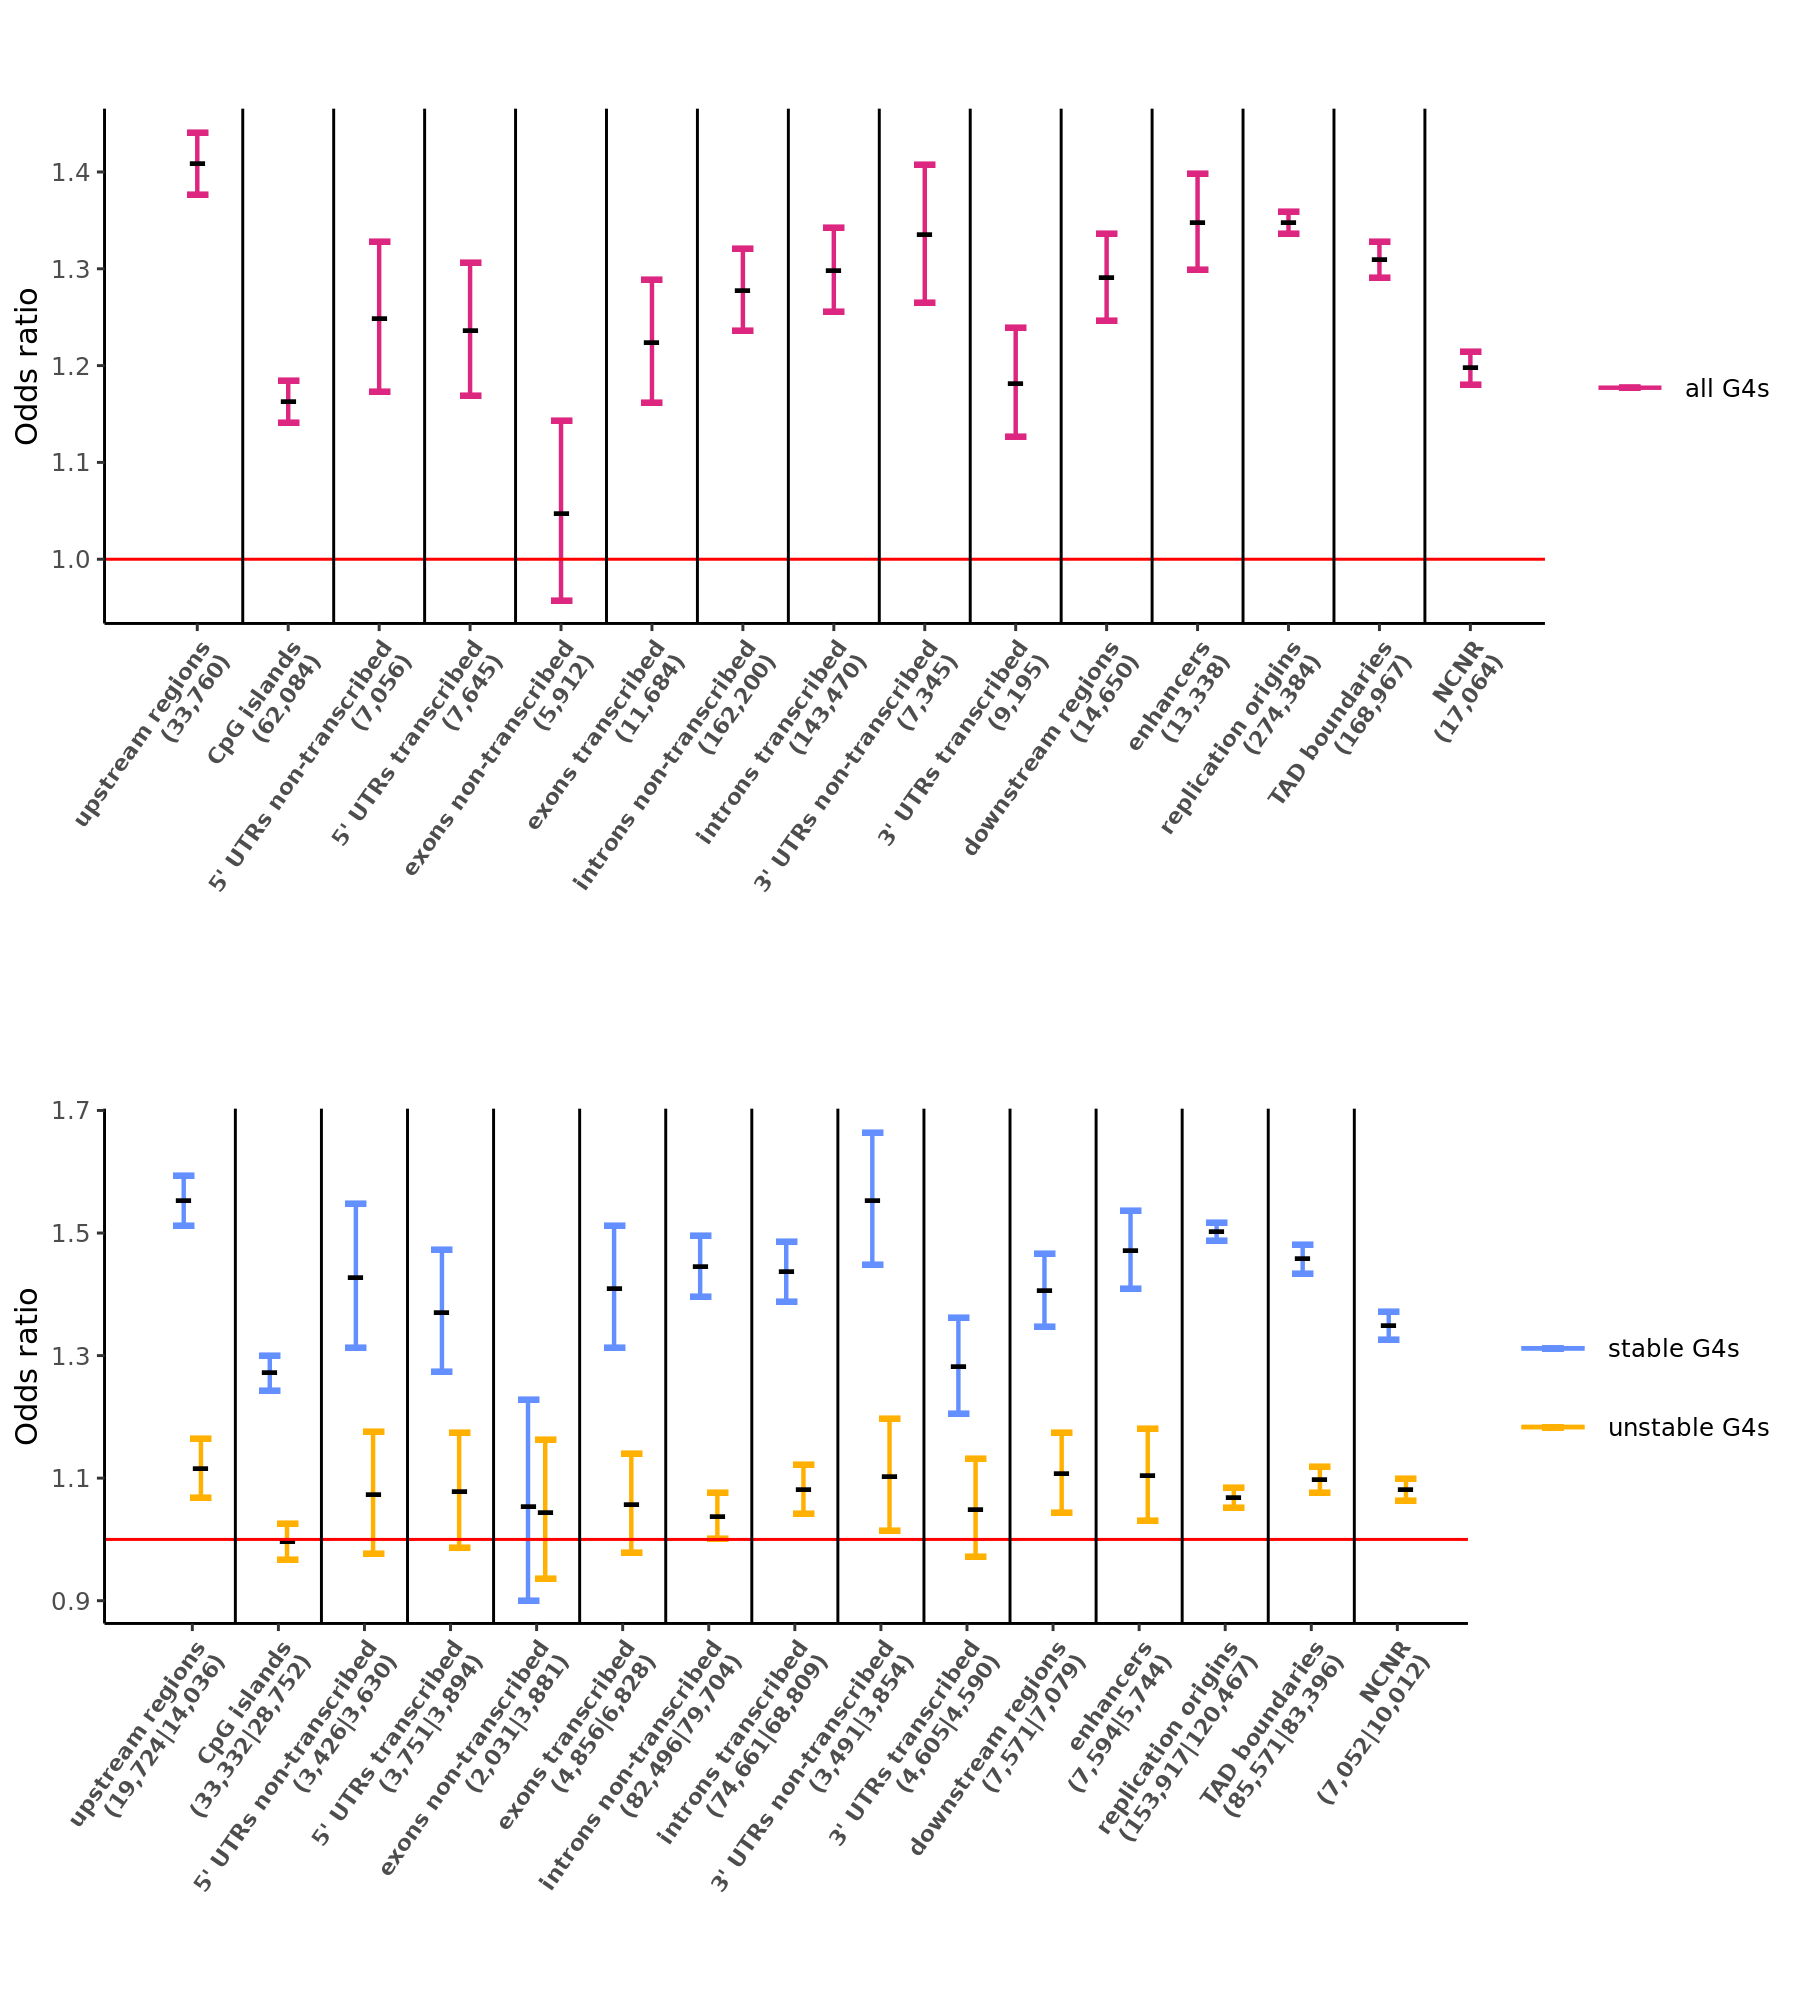

In [33]:
%%R -w 9 -h 10 --units in -r 200


xlegend = c("upstream regions\n(33,760)", "CpG islands\n(62,084)","5' UTRs non-transcribed\n(7,056)",
            "5' UTRs transcribed\n(7,645)","exons non-transcribed\n(5,912)",
            "exons transcribed\n(11,684)","introns non-transcribed\n(162,200)",
            "introns transcribed\n(143,470)","3' UTRs non-transcribed\n(7,345)",
            "3' UTRs transcribed\n(9,195)","downstream regions\n(14,650)","enhancers\n(13,338)",
            "replication origins\n(274,384)","TAD boundaries\n(168,967)","NCNR\n(17,064)")



dataf <- cbind.data.frame(xlegend,x,ORs,Low_ORs,High_ORs,Ls,Low_Ls,High_Ls,Us,Low_Us,High_Us)
names(dataf) <- c("xlegend","x","ORs","Low_ORs","High_ORs","Ls","Low_Ls","High_Ls",
                  "Us","Low_Us","High_Us")

cols <- c("all"="#DC267F",
          "high"="#648FFF",
          "low"="#FFB000")


g1 <- ggplot(dataf,) +
   geom_segment(aes(x=(x), xend=(x), y=Ls, yend=Us, colour="all"), size=0.75) +

   geom_point(aes(x=(x), y=ORs),shape='-', size=7) +
   geom_point(aes(x=(x), y=Us, colour="all"),shape='-', size=10) +
   geom_point(aes(x=(x), y=Ls, colour="all"),shape='-', size=10) +


   geom_hline(yintercept=1, color="red") +
   geom_vline(xintercept=1.5, color="black") +
   geom_vline(xintercept=2.5, color="black") +
   geom_vline(xintercept=3.5, color="black") +
   geom_vline(xintercept=4.5, color="black") +
   geom_vline(xintercept=5.5, color="black") +
   geom_vline(xintercept=6.5, color="black") +
   geom_vline(xintercept=7.5, color="black") +
   geom_vline(xintercept=8.5, color="black") +
   geom_vline(xintercept=9.5, color="black") +
   geom_vline(xintercept=10.5, color="black") +
   geom_vline(xintercept=11.5, color="black") +
   geom_vline(xintercept=12.5, color="black") +
   geom_vline(xintercept=13.5, color="black") +
   geom_vline(xintercept=14.5, color="black") +


   theme_classic() + labs(subtitle="Classic Theme")+
   scale_x_continuous(limits = c(0.7,15.1),  breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),labels=xlegend) +
   theme(axis.text.x=element_text(angle = 55, hjust = 1,family="sans",face="bold",size=8)) +
   scale_colour_manual(name="",values=cols,labels="all G4s") + 
   labs(title="", subtitle="", y="Odds ratio", x="", caption="",family="sans")


xlegend = c("upstream regions\n(19,724|14,036)", "CpG islands\n(33,332|28,752)","5' UTRs non-transcribed\n(3,426|3,630)",
            "5' UTRs transcribed\n(3,751|3,894)","exons non-transcribed\n(2,031|3,881)",
            "exons transcribed\n(4,856|6,828)","introns non-transcribed\n(82,496|79,704)",
            "introns transcribed\n(74,661|68,809)","3' UTRs non-transcribed\n(3,491|3,854)",
            "3' UTRs transcribed\n(4,605|4,590)","downstream regions\n(7,571|7,079)","enhancers\n(7,594|5,744)",
            "replication origins\n(153,917|120,467)","TAD boundaries\n(85,571|83,396)","NCNR\n(7,052|10,012)")

dataf <- cbind.data.frame(xlegend,x,ORs,Low_ORs,High_ORs,Ls,Low_Ls,High_Ls,Us,Low_Us,High_Us)
names(dataf) <- c("xlegend","x","ORs","Low_ORs","High_ORs","Ls","Low_Ls","High_Ls",
                  "Us","Low_Us","High_Us")

cols <- c("all"="#DC267F",
          "high"="#648FFF",
          "low"="#FFB000")


g2 <- ggplot(dataf,) +
   geom_segment(aes(x=(x+0.1), xend=(x+0.1), y=Low_Ls, yend=Low_Us, colour="low"), size=0.75) +
   geom_segment(aes(x=(x-0.1), xend=(x-0.1), y=High_Ls, yend=High_Us, colour="high"), size=0.75) +

   geom_point(aes(x=(x+0.1), y=Low_ORs),shape='-',size=7) +
   geom_point(aes(x=(x-0.1), y=High_ORs),shape='-',size=7) +
   geom_point(aes(x=(x+0.1), y=Low_Us, colour="low"),shape='-', size=10) +
   geom_point(aes(x=(x+0.1), y=Low_Ls, colour="low"),shape='-', size=10) +
   geom_point(aes(x=(x-0.1), y=High_Us, colour="high"),shape='-', size=10) +
   geom_point(aes(x=(x-0.1), y=High_Ls, colour="high"),shape='-', size=10) +

   geom_hline(yintercept=1, color="red") +
   geom_vline(xintercept=1.5, color="black") +
   geom_vline(xintercept=2.5, color="black") +
   geom_vline(xintercept=3.5, color="black") +
   geom_vline(xintercept=4.5, color="black") +
   geom_vline(xintercept=5.5, color="black") +
   geom_vline(xintercept=6.5, color="black") +
   geom_vline(xintercept=7.5, color="black") +
   geom_vline(xintercept=8.5, color="black") +
   geom_vline(xintercept=9.5, color="black") +
   geom_vline(xintercept=10.5, color="black") +
   geom_vline(xintercept=11.5, color="black") +
   geom_vline(xintercept=12.5, color="black") +
   geom_vline(xintercept=13.5, color="black") +
   geom_vline(xintercept=14.5, color="black") +

   theme_classic() + labs(subtitle="Classic Theme")+
   scale_x_continuous(limits = c(0.7,15.1),  breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),labels=xlegend) +
   theme(axis.text.x=element_text(angle = 55, hjust = 1, face="bold",family="sans",size=8)) +
   scale_colour_manual(name="",values=cols,labels=c('stable G4s','unstable G4s')) + 
   labs(title="", subtitle="", y="Odds ratio", x="", caption="",family="sans")

grid.arrange(g1,g2,nrow=2)
G <- arrangeGrob(g1,g2,nrow=2)
ggsave(file='HKA.pdf',G, width=9, height=10, dpi=300)







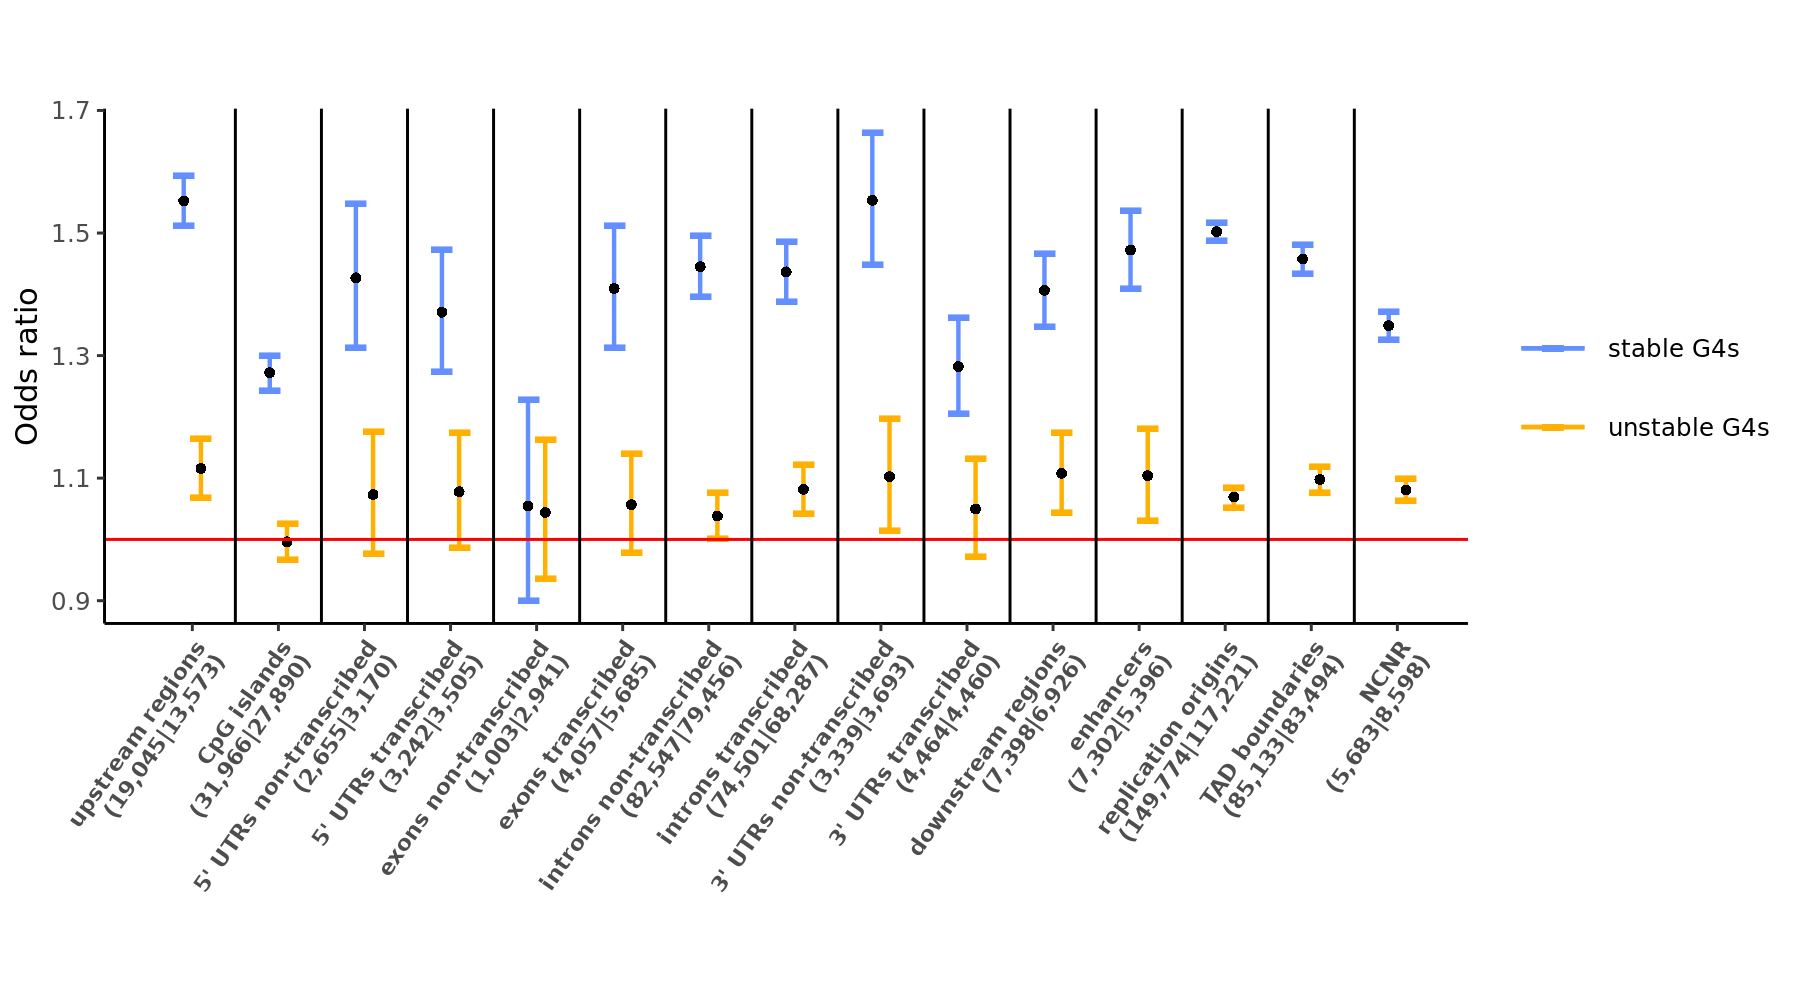

In [799]:
%%R -w 9 -h 5 --units in -r 200


xlegend = c("upstream regions\n(19,045|13,573)", "CpG islands\n(31,966|27,890)","5' UTRs non-transcribed\n(2,655|3,170)",
            "5' UTRs transcribed\n(3,242|3,505)","exons non-transcribed\n(1,003|2,941)",
            "exons transcribed\n(4,057|5,685)","introns non-transcribed\n(82,547|79,456)",
            "introns transcribed\n(74,501|68,287)","3' UTRs non-transcribed\n(3,339|3,693)",
            "3' UTRs transcribed\n(4,464|4,460)","downstream regions\n(7,398|6,926)","enhancers\n(7,302|5,396)",
            "replication origins\n(149,774|117,221)","TAD boundaries\n(85,133|83,494)","NCNR\n(5,683|8,598)")

dataf <- cbind.data.frame(xlegend,x,ORs,Low_ORs,High_ORs,Ls,Low_Ls,High_Ls,Us,Low_Us,High_Us)
names(dataf) <- c("xlegend","x","ORs","Low_ORs","High_ORs","Ls","Low_Ls","High_Ls",
                  "Us","Low_Us","High_Us")

cols <- c("all"="#DC267F",
          "high"="#648FFF",
          "low"="#FFB000")


g <- ggplot(dataf,) +
   geom_segment(aes(x=(x+0.1), xend=(x+0.1), y=Low_Ls, yend=Low_Us, colour="low"), size=0.75) +
   geom_segment(aes(x=(x-0.1), xend=(x-0.1), y=High_Ls, yend=High_Us, colour="high"), size=0.75) +

   geom_point(aes(x=(x+0.1), y=Low_ORs),shape=16) +
   geom_point(aes(x=(x-0.1), y=High_ORs),shape=16) +
   geom_point(aes(x=(x+0.1), y=Low_Us, colour="low"),shape='-', size=10) +
   geom_point(aes(x=(x+0.1), y=Low_Ls, colour="low"),shape='-', size=10) +
   geom_point(aes(x=(x-0.1), y=High_Us, colour="high"),shape='-', size=10) +
   geom_point(aes(x=(x-0.1), y=High_Ls, colour="high"),shape='-', size=10) +

   geom_hline(yintercept=1, color="red") +
   geom_vline(xintercept=1.5, color="black") +
   geom_vline(xintercept=2.5, color="black") +
   geom_vline(xintercept=3.5, color="black") +
   geom_vline(xintercept=4.5, color="black") +
   geom_vline(xintercept=5.5, color="black") +
   geom_vline(xintercept=6.5, color="black") +
   geom_vline(xintercept=7.5, color="black") +
   geom_vline(xintercept=8.5, color="black") +
   geom_vline(xintercept=9.5, color="black") +
   geom_vline(xintercept=10.5, color="black") +
   geom_vline(xintercept=11.5, color="black") +
   geom_vline(xintercept=12.5, color="black") +
   geom_vline(xintercept=13.5, color="black") +
   geom_vline(xintercept=14.5, color="black") +

   theme_classic() + labs(subtitle="Classic Theme")+
   scale_x_continuous(limits = c(0.7,15.1),  breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),labels=xlegend) +
   theme(axis.text.x=element_text(angle = 55, hjust = 1, face="bold",family="sans",size=8)) +
   scale_colour_manual(name="",values=cols,labels=c('stable G4s','unstable G4s')) + 
   labs(title="", subtitle="", y="Odds ratio", x="", caption="",family="sans")

grid.arrange(g)
G <- arrangeGrob(g)
ggsave(file='HKA_highlow.pdf',G, width=9, height=5, dpi=300)



In [629]:
%%R

NCNR_fisher_highvlow <- fisher.test(cbind(c(29040, 179366),c(30118, 232166)))
print(paste('NCNR high v low',NCNR_fisher_highvlow$estimate,NCNR_fisher_highvlow$p.value))
print(NCNR_fisher_highvlow)

Upstream_fisher_highvlow <- fisher.test(cbind(c(6948, 36771),c(2448, 18026)))
print(paste('Up high v low',Upstream_fisher_highvlow$estimate,Upstream_fisher_highvlow$p.value))

FUTR_fisher_sense_highvlow <- fisher.test(cbind(c(692, 3698),c(528, 3752)))
print(paste('5UTR sense high v low',FUTR_fisher_sense_highvlow$estimate,FUTR_fisher_sense_highvlow$p.value))

FUTR_fisher_antisense_highvlow <- fisher.test(cbind(c(898, 4996),c(600, 4245)))
print(paste('5UTR antisense high v low',FUTR_fisher_antisense_highvlow$estimate,FUTR_fisher_antisense_highvlow$p.value))

Exon_fisher_sense_highvlow <- fisher.test(cbind(c(195, 1151),c(393, 2343)))
print(paste('Exon sense high v low',Exon_fisher_sense_highvlow$estimate,Exon_fisher_sense_highvlow$p.value))

Exon_fisher_antisense_highvlow <- fisher.test(cbind(c(968, 4274),c(801, 4718)))
print(paste('Exon antisense high v low',Exon_fisher_antisense_highvlow$estimate,Exon_fisher_antisense_highvlow$p.value))

Intron_fisher_sense_highvlow <- fisher.test(cbind(c(28521, 163609),c(14309, 114249)))
print(paste('Intron sense high v low',Intron_fisher_sense_highvlow$estimate,Intron_fisher_sense_highvlow$p.value))

Intron_fisher_antisense_highvlow <- fisher.test(cbind(c(28147, 162411),c(13495, 103428)))
print(paste('Intron antisense high v low',Intron_fisher_antisense_highvlow$estimate,Intron_fisher_antisense_highvlow$p.value))

TUTR_fisher_sense_highvlow <- fisher.test(cbind(c(973, 4999),c(649, 4698)))
print(paste('3UTR sense high v low',TUTR_fisher_sense_highvlow$estimate,TUTR_fisher_sense_highvlow$p.value))

TUTR_fisher_antisense_highvlow <- fisher.test(cbind(c(1228, 7645),c(761, 5787)))
print(paste('3UTR antisense high v low',TUTR_fisher_antisense_highvlow$estimate,TUTR_fisher_antisense_highvlow$p.value))

Downstream_fisher_highvlow <- fisher.test(cbind(c(2568, 15724),c(1271, 9880)))
print(paste('Down high v low',Downstream_fisher_highvlow$estimate,Downstream_fisher_highvlow$p.value))

Oris_fisher_highvlow <- fisher.test(cbind(c(48685, 267964),c(19152, 148105)))
print(paste('Oris high v low',Oris_fisher_highvlow$estimate,Oris_fisher_highvlow$p.value))

Enhancers_fisher_highvlow <- fisher.test(cbind(c(2549, 13572),c(977, 6937)))
print(paste('Enhancers high v low', Enhancers_fisher_highvlow$estimate,Enhancers_fisher_highvlow$p.value))

TADB_fisher_highvlow <- fisher.test(cbind(c(29642, 170462),c(15607, 119163)))
print(paste('TADB high v low', TADB_fisher_highvlow$estimate,TADB_fisher_highvlow$p.value))

CpGI_fisher_highvlow <- fisher.test(cbind(c(10120, 56369),c(5230, 37197)))
print(paste('CpGI high v low', CpGI_fisher_highvlow$estimate,CpGI_fisher_highvlow$p.value))



[1] "NCNR high v low 1.24803212199888 2.03096795917292e-139"

	Fisher's Exact Test for Count Data

data:  cbind(c(29040, 179366), c(30118, 232166))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.226629 1.269821
sample estimates:
odds ratio 
  1.248032 

[1] "Up high v low 1.391361316676 1.37581691424796e-40"
[1] "5UTR sense high v low 1.3296931671024 4.74793622558623e-06"
[1] "5UTR antisense high v low 1.27165625421897 2.08642841926392e-05"
[1] "Exon sense high v low 1.01004161018301 0.924490759669745"
[1] "Exon antisense high v low 1.33398583946064 3.37929520593627e-08"
[1] "Intron sense high v low 1.39187230668259 2.13359010469109e-205"
[1] "Intron antisense high v low 1.32825370372033 6.67036600042132e-145"
[1] "3UTR sense high v low 1.40890723277994 3.05020142754629e-10"
[1] "3UTR antisense high v low 1.22147251744749 4.89626113825615e-05"
[1] "Down high v low 1.26952019645597 5.04731362195521e-11"
[1] "Oris high v low

In [630]:
%%R
#https://stackoverflow.com/questions/14069629/how-can-i-plot-data-with-confidence-intervals

x <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)

#print(length(x))

ORs <- c(Upstream_fisher_highvlow$estimate,
         CpGI_fisher_highvlow$estimate,
         FUTR_fisher_sense_highvlow$estimate,
         FUTR_fisher_antisense_highvlow$estimate,
         Exon_fisher_sense_highvlow$estimate,
         Exon_fisher_antisense_highvlow$estimate,
         Intron_fisher_sense_highvlow$estimate,
         Intron_fisher_antisense_highvlow$estimate,
         TUTR_fisher_sense_highvlow$estimate,
         TUTR_fisher_antisense_highvlow$estimate,
         Downstream_fisher_highvlow$estimate,
         Oris_fisher_highvlow$estimate,
         Enhancers_fisher_highvlow$estimate,
         TADB_fisher_highvlow$estimate,
         NCNR_fisher_highvlow$estimate)



Ls <- c(Upstream_fisher_highvlow$conf.int[1],
        CpGI_fisher_highvlow$conf.int[1],
        FUTR_fisher_sense_highvlow$conf.int[1],
        FUTR_fisher_antisense_highvlow$conf.int[1],
        Exon_fisher_sense_highvlow$conf.int[1],
        Exon_fisher_antisense_highvlow$conf.int[1],
        Intron_fisher_sense_highvlow$conf.int[1],
        Intron_fisher_antisense_highvlow$conf.int[1],
        TUTR_fisher_sense_highvlow$conf.int[1],
        TUTR_fisher_antisense_highvlow$conf.int[1],
        Downstream_fisher_highvlow$conf.int[1],
        Oris_fisher_highvlow$conf.int[1],
        Enhancers_fisher_highvlow$conf.int[1],
        TADB_fisher_highvlow$conf.int[1],
        NCNR_fisher_highvlow$conf.int[1])




Us <- c(Upstream_fisher_highvlow$conf.int[2],
        CpGI_fisher_highvlow$conf.int[2],
        FUTR_fisher_sense_highvlow$conf.int[2],
        FUTR_fisher_antisense_highvlow$conf.int[2],
        Exon_fisher_sense_highvlow$conf.int[2],
        Exon_fisher_antisense_highvlow$conf.int[2],
        Intron_fisher_sense_highvlow$conf.int[2],
        Intron_fisher_antisense_highvlow$conf.int[2],
        TUTR_fisher_sense_highvlow$conf.int[2],
        TUTR_fisher_antisense_highvlow$conf.int[2],
        Downstream_fisher_highvlow$conf.int[2],
        Oris_fisher_highvlow$conf.int[2],
        Enhancers_fisher_highvlow$conf.int[2],
        TADB_fisher_highvlow$conf.int[2],
        NCNR_fisher_highvlow$conf.int[2])




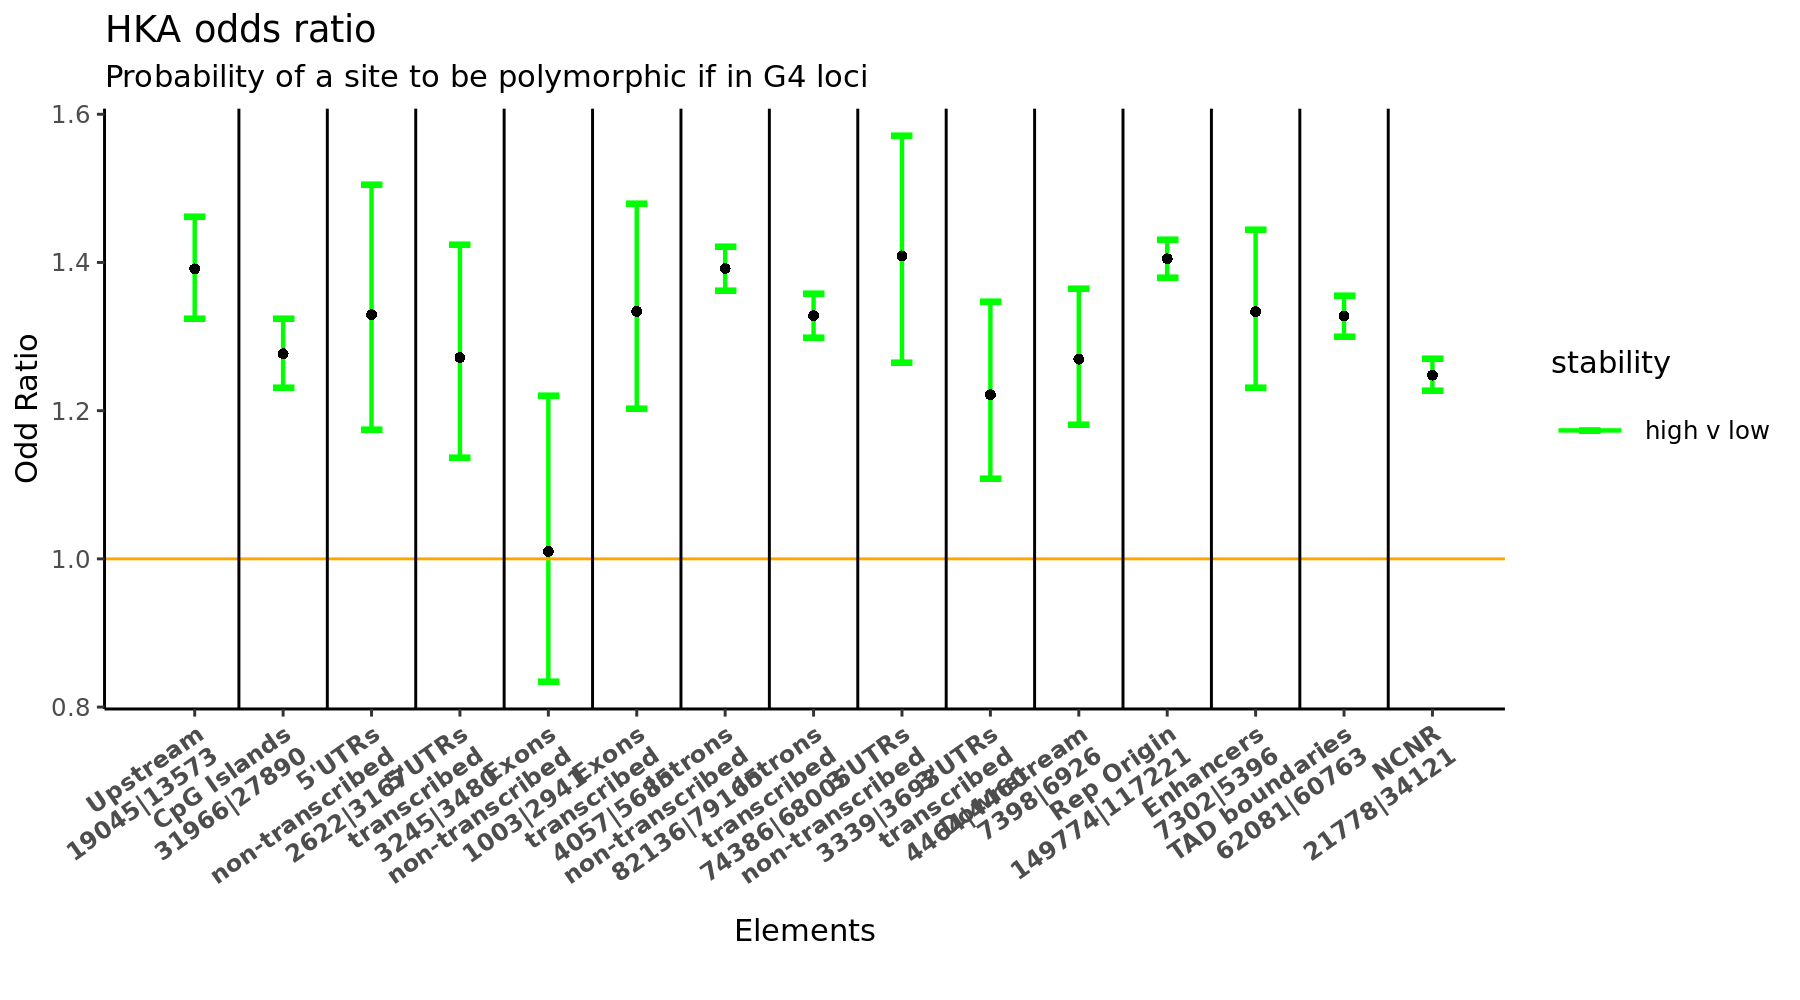

In [631]:
%%R -w 9 -h 5 --units in -r 200

xlegend = c("Upstream\n19045|13573", "CpG Islands\n31966|27890","5'UTRs\nnon-transcribed\n2622|3167",
            "5'UTRs\ntranscribed\n3245|3480","Exons\nnon-transcribed\n1003|2941",
            "Exons\ntranscribed\n4057|5685","Introns\nnon-transcribed\n82136|79165",
            "Introns\ntranscribed\n74386|68005","3'UTRs\nnon-transcribed\n3339|3693",
            "3'UTRs\ntranscribed\n4464|4460","Downstream\n7398|6926","Rep Origin\n149774|117221",
            "Enhancers\n7302|5396","TAD boundaries\n62081|60763","NCNR\n21778|34121")


dataf <- cbind.data.frame(xlegend,x,ORs,Ls,Us)
names(dataf) <- c("xlegend","x","ORs","Ls","Us")

cols <- c("all"="gold",
          "high"="red",
          "low"="blue",
          "high v low"="green")


ggplot(dataf,) +
   geom_segment(aes(x=(x), xend=(x), y=Ls, yend=Us, colour="high v low"), size=0.75) +

   geom_point(aes(x=(x), y=ORs),shape=16) +
   geom_point(aes(x=(x), y=Us, colour="high v low"),shape='-', size=10) +
   geom_point(aes(x=(x), y=Ls, colour="high v low"),shape='-', size=10) +

   geom_hline(yintercept=1, color="orange") +
   geom_vline(xintercept=1.5, color="black") +
   geom_vline(xintercept=2.5, color="black") +
   geom_vline(xintercept=3.5, color="black") +
   geom_vline(xintercept=4.5, color="black") +
   geom_vline(xintercept=5.5, color="black") +
   geom_vline(xintercept=6.5, color="black") +
   geom_vline(xintercept=7.5, color="black") +
   geom_vline(xintercept=8.5, color="black") +
   geom_vline(xintercept=9.5, color="black") +
   geom_vline(xintercept=10.5, color="black") +
   geom_vline(xintercept=11.5, color="black") +
   geom_vline(xintercept=12.5, color="black") +
   geom_vline(xintercept=13.5, color="black") +
   geom_vline(xintercept=14.5, color="black") +


   theme_classic() + labs(subtitle="Classic Theme")+
   scale_x_continuous(limits = c(0.7,15.1),  breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),labels=xlegend) +
   theme(axis.text.x=element_text(face="bold",angle = 35, hjust = 1)) +
   scale_colour_manual(name="stability",values=cols) + 
   labs(title="HKA odds ratio", subtitle="Probability of a site to be polymorphic if in G4 loci", y="Odd Ratio", x="Elements", caption="")


# Part IV. Site Frequency Spectrum


### NCNR

In [632]:
NCNR_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/NCNR.SFS.high.bed.test')
NCNR_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/NCNR.SFS.low.bed.test')
NCNR_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/NCNR.SFS.control.shuf')

NCNR_high_infile.seek(0)
NCNR_low_infile.seek(0)
NCNR_ctrl_infile.seek(0)

def list_MAFs(infile):
    
    already_parsed = {}
    MAFs = []
    for line in infile:
        array = line.strip().split('\t')
        key = array[0]+'|'+array[1]+'|'+array[2]
        #print(key)
        #break
        SFS = array[3]
        MAF = SFS.split('|')[4]
        
       
        if MAF != 'NA':
            if key not in already_parsed:

                if float(MAF) < 1: #remove fixed
                    MAF = float(MAF)

                    if MAF > 0.5:
                        if MAF >1:
                            print('ISSUE')
                            break
                            MAF = 1
                        MAF = 1-MAF
                        
                    if float(MAF) > 0.001792115*2: #remove single- and doubletons
                        MAFs.append(MAF)
                        
        already_parsed[key] = 0
    
    return(MAFs)

MAFs_high = list_MAFs(NCNR_high_infile)
MAFs_low = list_MAFs(NCNR_low_infile)
MAFs_ctrl = list_MAFs(NCNR_ctrl_infile)

min(MAFs_high)


0.00537634408602

In [633]:
%%R -i MAFs_ctrl,MAFs_high,MAFs_low

MAFs_high <- as.numeric(as.character(MAFs_high))
MAFs_low <- as.numeric(as.character(MAFs_low))
MAFs_ctrl <- as.numeric(as.character(MAFs_ctrl))
MAFs <- c(MAFs_high,MAFs_low)

print(min(MAFs_high))
print(min(MAFs_low))
print(min(MAFs_ctrl))



[1] 0.005376344
[1] 0.005376344
[1] 0.005376344


In [634]:
%%R

KS <- ks.test(MAFs_high,MAFs_ctrl)
print(KS)

KS <- ks.test(MAFs_low,MAFs_ctrl)
print(KS)

KS <- ks.test(MAFs,MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  MAFs_high and MAFs_ctrl
D = 0.069026, p-value = 4.12e-10
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  MAFs_low and MAFs_ctrl
D = 0.030042, p-value = 0.05207
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  MAFs and MAFs_ctrl
D = 0.0464, p-value = 3.035e-08
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.63450998   G4
2 0.10 0.09252357   G4
3 0.15 0.05327779   G4
4 0.20 0.04363078   G4
5 0.25 0.03836878   G4
6 0.30 0.03025652   G4


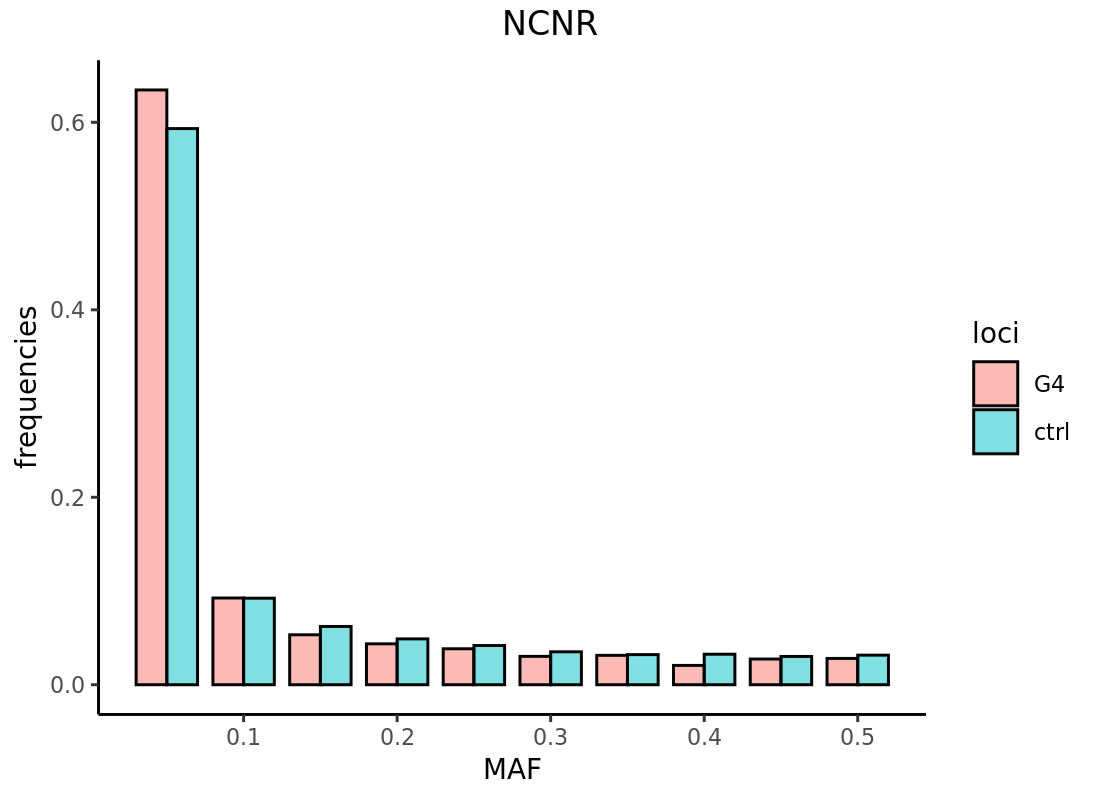

In [765]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(MAFs, plot=FALSE, breaks = 10)$density / sum(hist(MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("NCNR",gp=gpar(fontsize=12,font=1)))








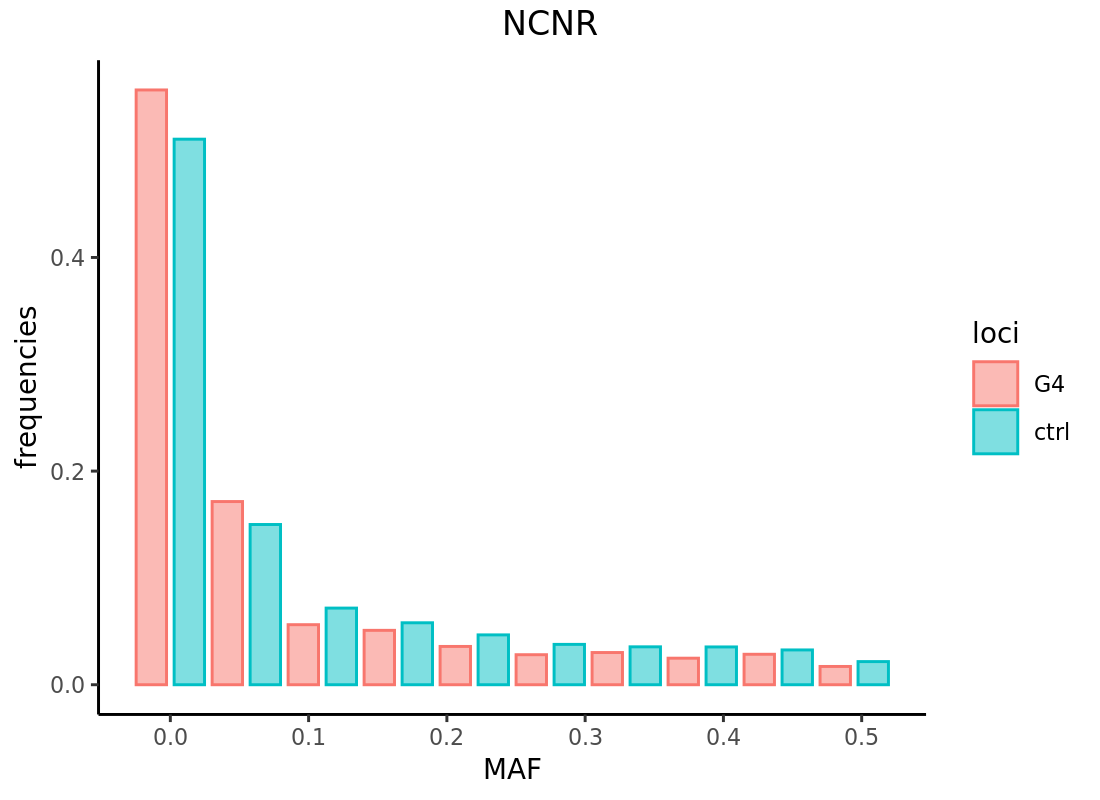

In [749]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)

toplot <- cbind.data.frame(c(MAFs_high,MAFs_ctrl),c(rep('G4',length(MAFs_high)),rep('ctrl',length(MAFs_ctrl))))
colnames(toplot) <- c('MAF', 'loci')



p1 <- ggplot(data=toplot, aes(x=MAF, fill=loci, colour=loci)) + 
    geom_histogram(aes(y=2*(..density..)/sum(..density..)),position=position_dodge2(preserve = "single", padding = 0.2, width = 0.5), bins = 10, alpha = .5)+
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("NCNR",gp=gpar(fontsize=12,font=1)))


In [636]:
UP_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Upstream1k.SFS.high.test')
UP_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Upstream1k.SFS.low.test')
UP_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Upstream1k.SFS.control')

UP_MAFs_high = list_MAFs(UP_high_infile)
UP_MAFs_low = list_MAFs(UP_low_infile)
UP_MAFs_ctrl = list_MAFs(UP_ctrl_infile)



In [637]:
%%R -i UP_MAFs_ctrl,UP_MAFs_high,UP_MAFs_low

UP_MAFs_high <- as.numeric(as.character(UP_MAFs_high))
UP_MAFs_low <- as.numeric(as.character(UP_MAFs_low))
UP_MAFs_ctrl <- as.numeric(as.character(UP_MAFs_ctrl))
UP_MAFs <- c(UP_MAFs_high,UP_MAFs_low)

In [639]:
%%R

KS <- ks.test(UP_MAFs_high,UP_MAFs_ctrl)
print(KS)

KS <- ks.test(UP_MAFs_low,UP_MAFs_ctrl)
print(KS)

KS <- ks.test(UP_MAFs,UP_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  UP_MAFs_high and UP_MAFs_ctrl
D = 0.087849, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  UP_MAFs_low and UP_MAFs_ctrl
D = 0.044375, p-value = 4.421e-07
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  UP_MAFs and UP_MAFs_ctrl
D = 0.077158, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.67322600   G4
2 0.10 0.09809183   G4
3 0.15 0.05336911   G4
4 0.20 0.03762671   G4
5 0.25 0.02784735   G4
6 0.30 0.02641622   G4


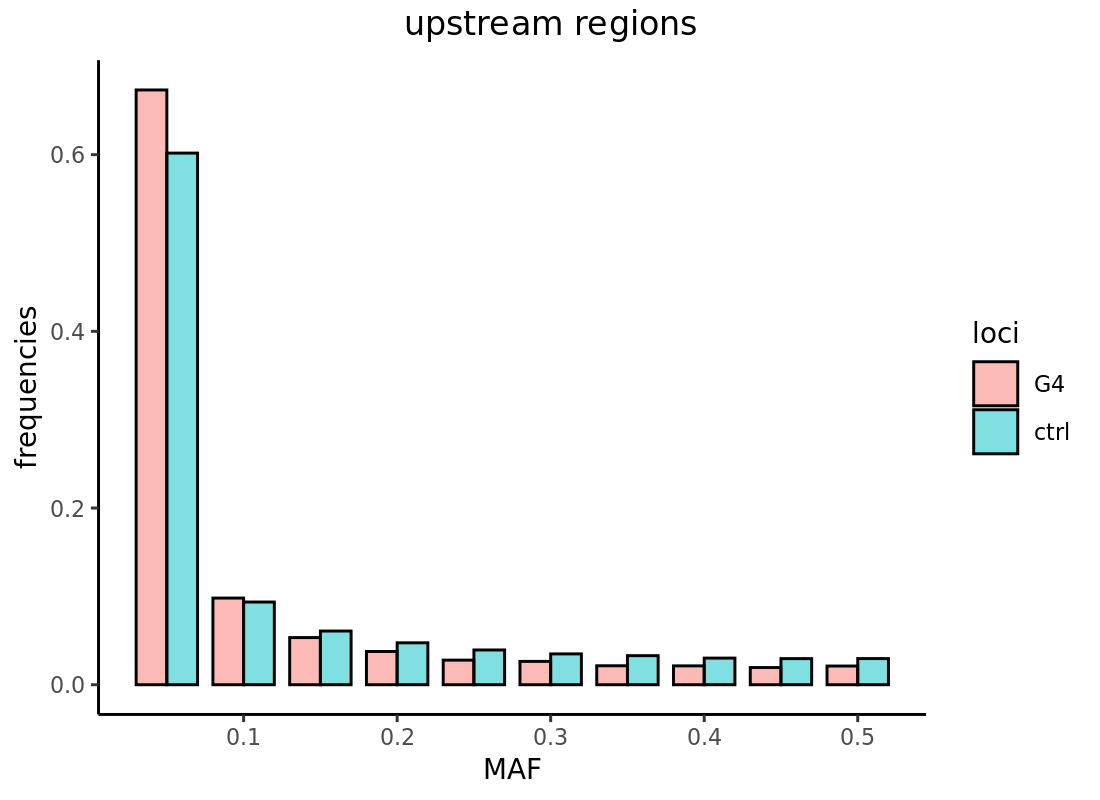

In [767]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)



hist_high <- hist(UP_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(UP_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(UP_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(UP_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("upstream regions",gp=gpar(fontsize=12,font=1)))








In [641]:
FUTR_sense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.high.sens.test')
FUTR_sense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.low.sens.test')
FUTR_sense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.control')

FUTR_sense_MAFs_high = list_MAFs(FUTR_sense_high_infile)
FUTR_sense_MAFs_low = list_MAFs(FUTR_sense_low_infile)
FUTR_sense_MAFs_ctrl = list_MAFs(FUTR_sense_ctrl_infile)



In [642]:
%%R -i FUTR_sense_MAFs_ctrl,FUTR_sense_MAFs_high,FUTR_sense_MAFs_low

FUTR_sense_MAFs_high <- as.numeric(as.character(FUTR_sense_MAFs_high))
FUTR_sense_MAFs_low <- as.numeric(as.character(FUTR_sense_MAFs_low))
FUTR_sense_MAFs_ctrl <- as.numeric(as.character(FUTR_sense_MAFs_ctrl))
FUTR_sense_MAFs <- c(FUTR_sense_MAFs_high,FUTR_sense_MAFs_low)

KS <- ks.test(FUTR_sense_MAFs_high,FUTR_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(FUTR_sense_MAFs_low,FUTR_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(FUTR_sense_MAFs,FUTR_sense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  FUTR_sense_MAFs_high and FUTR_sense_MAFs_ctrl
D = 0.080046, p-value = 3.664e-06
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  FUTR_sense_MAFs_low and FUTR_sense_MAFs_ctrl
D = 0.063373, p-value = 0.003958
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  FUTR_sense_MAFs and FUTR_sense_MAFs_ctrl
D = 0.068319, p-value = 1.159e-07
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.67286652   G4
2 0.10 0.09518600   G4
3 0.15 0.04376368   G4
4 0.20 0.03938731   G4
5 0.25 0.02789934   G4
6 0.30 0.01969365   G4


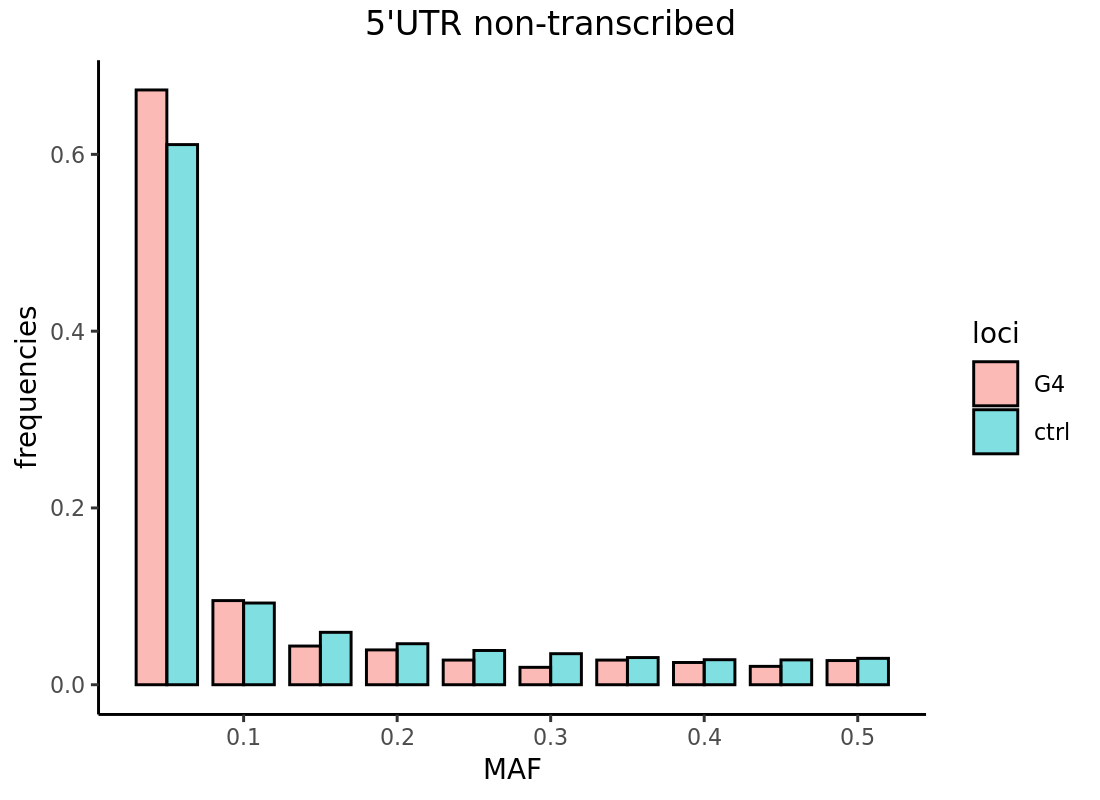

In [769]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(FUTR_sense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(FUTR_sense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(FUTR_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(FUTR_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("5'UTR non-transcribed",gp=gpar(fontsize=12,font=1)))



In [644]:
FUTR_antisense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.high.antisens.test')
FUTR_antisense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.low.antisens.test')
FUTR_antisense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/FUTR.SFS.control')

FUTR_antisense_MAFs_high = list_MAFs(FUTR_antisense_high_infile)
FUTR_antisense_MAFs_low = list_MAFs(FUTR_antisense_low_infile)
FUTR_antisense_MAFs_ctrl = list_MAFs(FUTR_antisense_ctrl_infile)



In [645]:
%%R -i FUTR_antisense_MAFs_ctrl,FUTR_antisense_MAFs_high,FUTR_antisense_MAFs_low

FUTR_antisense_MAFs_high <- as.numeric(as.character(FUTR_antisense_MAFs_high))
FUTR_antisense_MAFs_low <- as.numeric(as.character(FUTR_antisense_MAFs_low))
FUTR_antisense_MAFs_ctrl <- as.numeric(as.character(FUTR_antisense_MAFs_ctrl))
FUTR_antisense_MAFs <- c(FUTR_antisense_MAFs_high,FUTR_antisense_MAFs_low)

KS <- ks.test(FUTR_antisense_MAFs_high,FUTR_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(FUTR_antisense_MAFs_low,FUTR_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(FUTR_antisense_MAFs,FUTR_antisense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  FUTR_antisense_MAFs_high and FUTR_antisense_MAFs_ctrl
D = 0.094906, p-value = 1.295e-10
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  FUTR_antisense_MAFs_low and FUTR_antisense_MAFs_ctrl
D = 0.014183, p-value = 0.993
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  FUTR_antisense_MAFs and FUTR_antisense_MAFs_ctrl
D = 0.060648, p-value = 2.129e-07
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.66488652   G4
2 0.10 0.08900757   G4
3 0.15 0.05340454   G4
4 0.20 0.04450378   G4
5 0.25 0.02892746   G4
6 0.30 0.02981753   G4


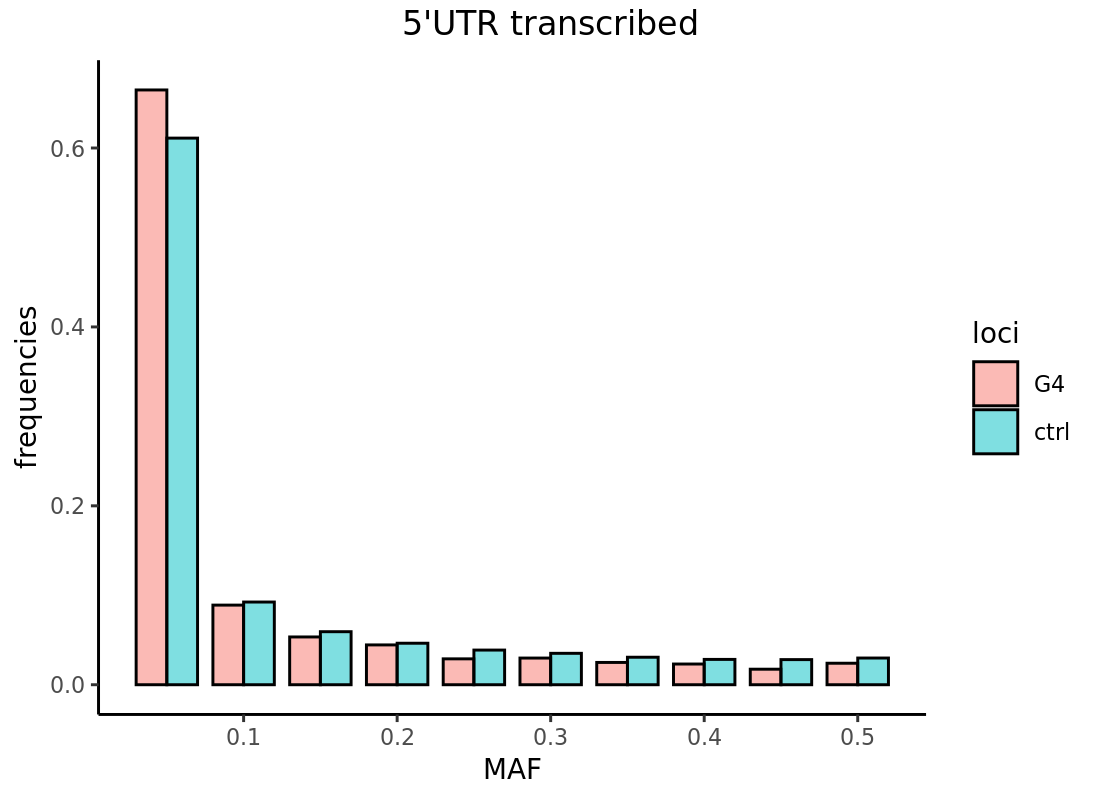

In [770]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)



hist_high <- hist(FUTR_antisense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(FUTR_antisense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(FUTR_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(FUTR_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("5'UTR transcribed",gp=gpar(fontsize=12,font=1)))



In [647]:
exon_sense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.sens.test')
exon_sense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.low.sens.test')
exon_sense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.control')

exon_sense_MAFs_high = list_MAFs(exon_sense_high_infile)
exon_sense_MAFs_low = list_MAFs(exon_sense_low_infile)
exon_sense_MAFs_ctrl = list_MAFs(exon_sense_ctrl_infile)



In [648]:
%%R -i exon_sense_MAFs_ctrl,exon_sense_MAFs_high,exon_sense_MAFs_low

exon_sense_MAFs_high <- as.numeric(as.character(exon_sense_MAFs_high))
exon_sense_MAFs_low <- as.numeric(as.character(exon_sense_MAFs_low))
exon_sense_MAFs_ctrl <- as.numeric(as.character(exon_sense_MAFs_ctrl))
exon_sense_MAFs <- c(exon_sense_MAFs_high,exon_sense_MAFs_low)

KS <- ks.test(exon_sense_MAFs_high,exon_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(exon_sense_MAFs_low,exon_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(exon_sense_MAFs,exon_sense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  exon_sense_MAFs_high and exon_sense_MAFs_ctrl
D = 0.053537, p-value = 0.4323
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  exon_sense_MAFs_low and exon_sense_MAFs_ctrl
D = 0.072533, p-value = 0.008014
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  exon_sense_MAFs and exon_sense_MAFs_ctrl
D = 0.059776, p-value = 0.00719
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.66834805   G4
2 0.10 0.09836066   G4
3 0.15 0.06809584   G4
4 0.20 0.03404792   G4
5 0.25 0.02522068   G4
6 0.30 0.03530895   G4


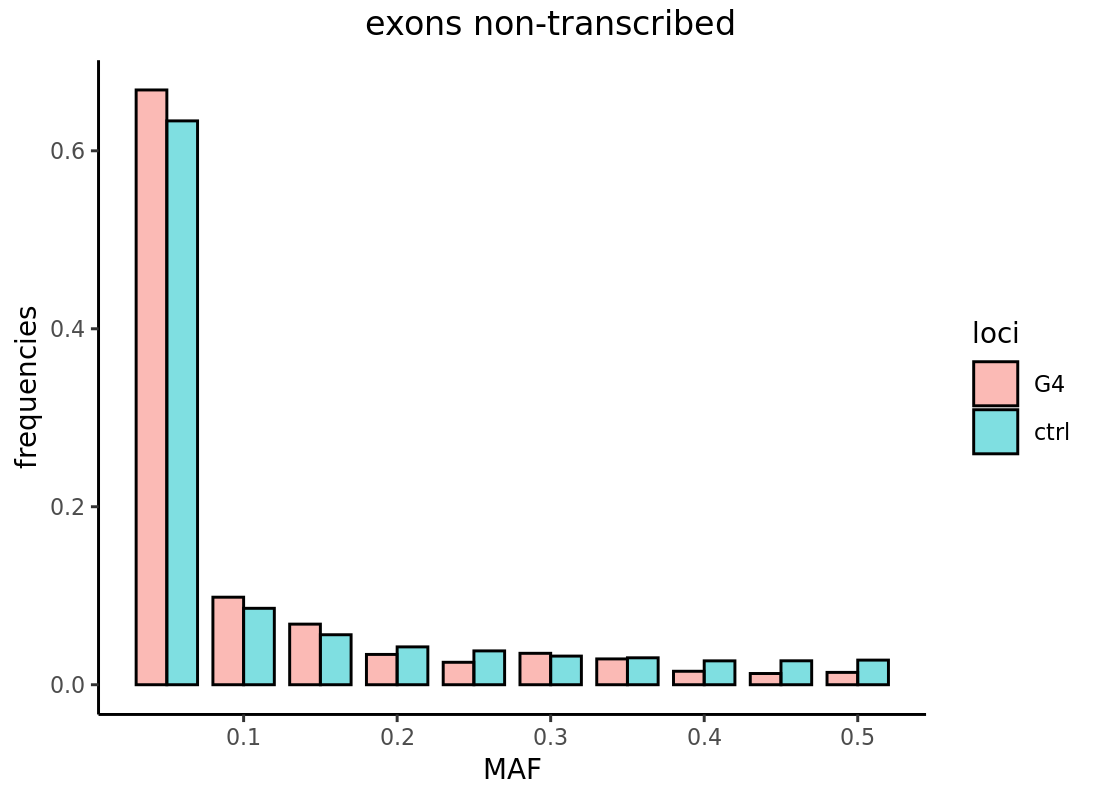

In [772]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)



hist_high <- hist(exon_sense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(exon_sense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(exon_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(exon_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("exons non-transcribed",gp=gpar(fontsize=12,font=1)))



In [650]:
exon_antisense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.antisens.test')
exon_antisense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.low.antisens.test')
exon_antisense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.control')

exon_antisense_MAFs_high = list_MAFs(exon_antisense_high_infile)
exon_antisense_MAFs_low = list_MAFs(exon_antisense_low_infile)
exon_antisense_MAFs_ctrl = list_MAFs(exon_antisense_ctrl_infile)



In [651]:
%%R -i exon_antisense_MAFs_ctrl,exon_antisense_MAFs_high,exon_antisense_MAFs_low

exon_antisense_MAFs_high <- as.numeric(as.character(exon_antisense_MAFs_high))
exon_antisense_MAFs_low <- as.numeric(as.character(exon_antisense_MAFs_low))
exon_antisense_MAFs_ctrl <- as.numeric(as.character(exon_antisense_MAFs_ctrl))
exon_antisense_MAFs <- c(exon_antisense_MAFs_high,exon_antisense_MAFs_low)

KS <- ks.test(exon_antisense_MAFs_high,exon_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(exon_antisense_MAFs_low,exon_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(exon_antisense_MAFs,exon_antisense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  exon_antisense_MAFs_high and exon_antisense_MAFs_ctrl
D = 0.061063, p-value = 7.954e-05
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  exon_antisense_MAFs_low and exon_antisense_MAFs_ctrl
D = 0.043147, p-value = 0.03487
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  exon_antisense_MAFs and exon_antisense_MAFs_ctrl
D = 0.048741, p-value = 2.022e-05
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.67974121   G4
2 0.10 0.08370400   G4
3 0.15 0.05418520   G4
4 0.20 0.04367165   G4
5 0.25 0.03234937   G4
6 0.30 0.02507076   G4


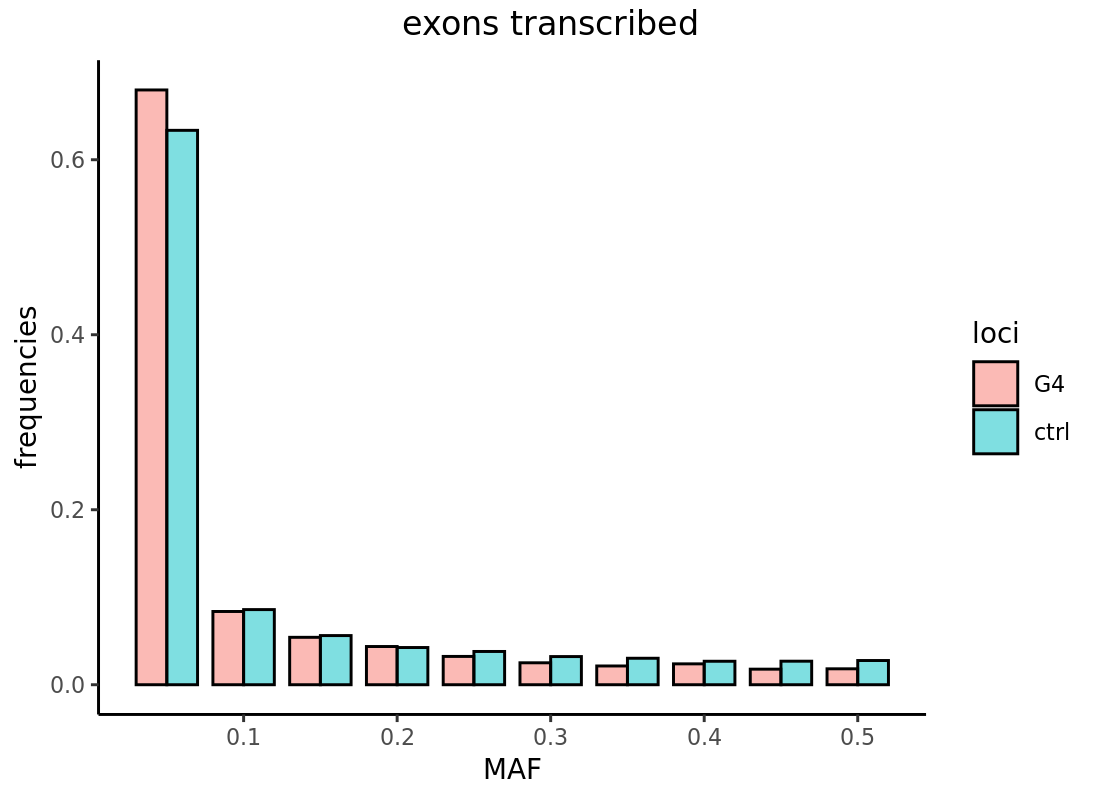

In [773]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(exon_antisense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(exon_antisense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(exon_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(exon_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("exons transcribed",gp=gpar(fontsize=12,font=1)))



In [653]:
intron_sense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.high.sens.test')
intron_sense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.low.sens.test')
intron_sense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.control.shuf')

intron_sense_MAFs_high = list_MAFs(intron_sense_high_infile)
intron_sense_MAFs_low = list_MAFs(intron_sense_low_infile)
intron_sense_MAFs_ctrl = list_MAFs(intron_sense_ctrl_infile)



In [654]:
%%R -i intron_sense_MAFs_ctrl,intron_sense_MAFs_high,intron_sense_MAFs_low

intron_sense_MAFs_high <- as.numeric(as.character(intron_sense_MAFs_high))
intron_sense_MAFs_low <- as.numeric(as.character(intron_sense_MAFs_low))
intron_sense_MAFs_ctrl <- as.numeric(as.character(intron_sense_MAFs_ctrl))
intron_sense_MAFs <- c(intron_sense_MAFs_high,intron_sense_MAFs_low)

KS <- ks.test(intron_sense_MAFs_high,intron_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(intron_sense_MAFs_low,intron_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(intron_sense_MAFs,intron_sense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  intron_sense_MAFs_high and intron_sense_MAFs_ctrl
D = 0.079739, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  intron_sense_MAFs_low and intron_sense_MAFs_ctrl
D = 0.033549, p-value = 2.793e-05
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  intron_sense_MAFs and intron_sense_MAFs_ctrl
D = 0.066349, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.65051669   G4
2 0.10 0.09841992   G4
3 0.15 0.05659944   G4
4 0.20 0.04215259   G4
5 0.25 0.03382426   G4
6 0.30 0.02825501   G4


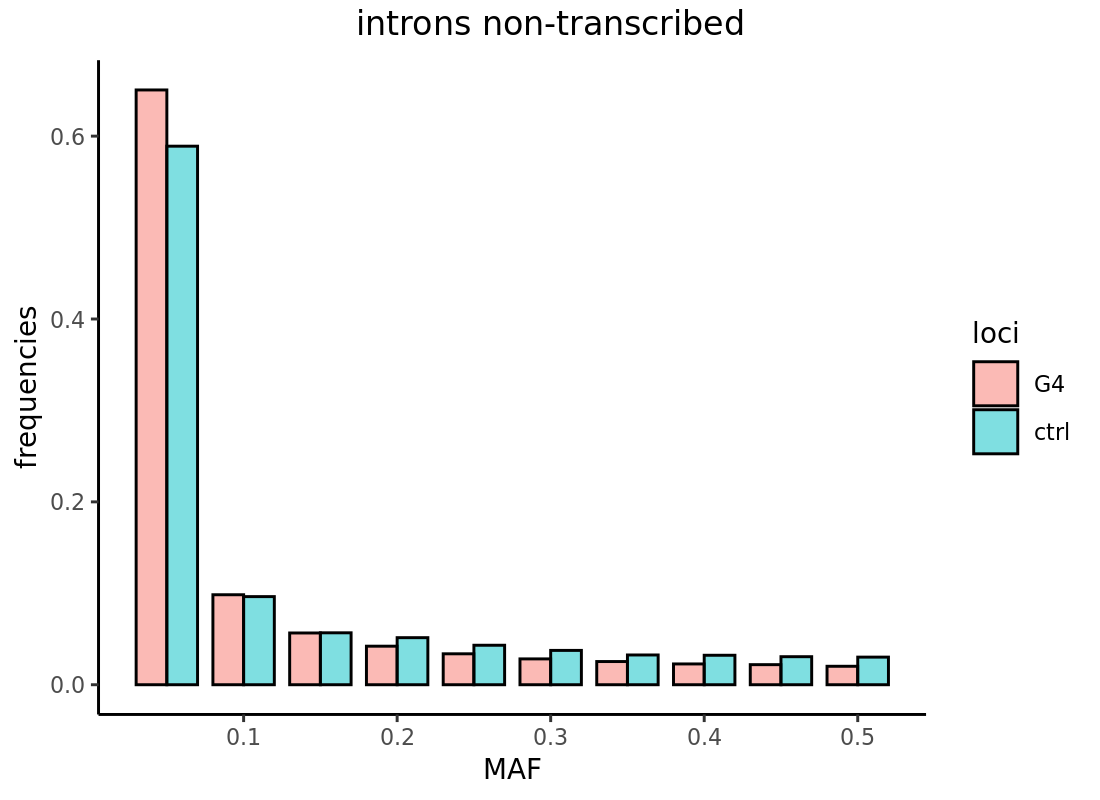

In [775]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)



hist_high <- hist(intron_sense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(intron_sense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(intron_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(intron_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("introns non-transcribed",gp=gpar(fontsize=12,font=1)))



In [656]:
intron_antisense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.high.antisens.test')
intron_antisense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.low.antisens.test')
intron_antisense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Introns.SFS.control.shuf')

intron_antisense_MAFs_high = list_MAFs(intron_antisense_high_infile)
intron_antisense_MAFs_low = list_MAFs(intron_antisense_low_infile)
intron_antisense_MAFs_ctrl = list_MAFs(intron_antisense_ctrl_infile)


In [657]:
%%R -i intron_antisense_MAFs_ctrl,intron_antisense_MAFs_high,intron_antisense_MAFs_low

intron_antisense_MAFs_high <- as.numeric(as.character(intron_antisense_MAFs_high))
intron_antisense_MAFs_low <- as.numeric(as.character(intron_antisense_MAFs_low))
intron_antisense_MAFs_ctrl <- as.numeric(as.character(intron_antisense_MAFs_ctrl))
intron_antisense_MAFs <- c(intron_antisense_MAFs_high,intron_antisense_MAFs_low)

KS <- ks.test(intron_antisense_MAFs_high,intron_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(intron_antisense_MAFs_low,intron_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(intron_antisense_MAFs,intron_antisense_MAFs_ctrl)
print(KS)


	Two-sample Kolmogorov-Smirnov test

data:  intron_antisense_MAFs_high and intron_antisense_MAFs_ctrl
D = 0.089356, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  intron_antisense_MAFs_low and intron_antisense_MAFs_ctrl
D = 0.059009, p-value = 1.332e-15
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  intron_antisense_MAFs and intron_antisense_MAFs_ctrl
D = 0.080358, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.66520778   G4
2 0.10 0.09731726   G4
3 0.15 0.05410631   G4
4 0.20 0.03942478   G4
5 0.25 0.03133141   G4
6 0.30 0.02571584   G4


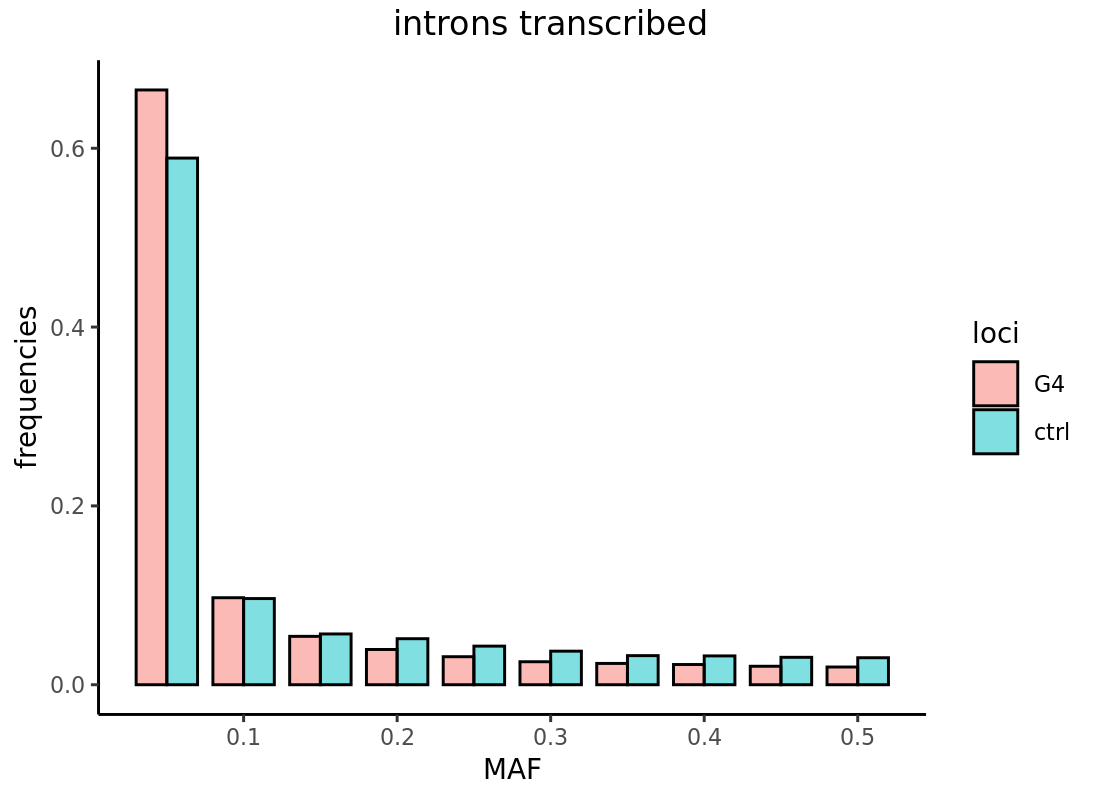

In [776]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(intron_antisense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(intron_antisense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(intron_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(intron_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("introns transcribed",gp=gpar(fontsize=12,font=1)))



In [659]:
TUTR_sense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.high.sens.test')
TUTR_sense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.low.sens.test')
TUTR_sense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.control')

TUTR_sense_MAFs_high = list_MAFs(TUTR_sense_high_infile)
TUTR_sense_MAFs_low = list_MAFs(TUTR_sense_low_infile)
TUTR_sense_MAFs_ctrl = list_MAFs(TUTR_sense_ctrl_infile)



In [660]:
%%R -i TUTR_sense_MAFs_ctrl,TUTR_sense_MAFs_high,TUTR_sense_MAFs_low

TUTR_sense_MAFs_high <- as.numeric(as.character(TUTR_sense_MAFs_high))
TUTR_sense_MAFs_low <- as.numeric(as.character(TUTR_sense_MAFs_low))
TUTR_sense_MAFs_ctrl <- as.numeric(as.character(TUTR_sense_MAFs_ctrl))
TUTR_sense_MAFs <- c(TUTR_transcribed_MAFs_high,TUTR_sense_MAFs_low)

KS <- ks.test(TUTR_sense_MAFs_high,TUTR_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(TUTR_sense_MAFs_low,TUTR_sense_MAFs_ctrl)
print(KS)

KS <- ks.test(TUTR_sense_MAFs,TUTR_sense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  TUTR_sense_MAFs_high and TUTR_sense_MAFs_ctrl
D = 0.071724, p-value = 4.522e-07
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TUTR_sense_MAFs_low and TUTR_sense_MAFs_ctrl
D = 0.050348, p-value = 0.02361
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TUTR_sense_MAFs and TUTR_sense_MAFs_ctrl
D = 0.49855, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.82874084   G4
2 0.10 0.05290083   G4
3 0.15 0.02720614   G4
4 0.20 0.02371817   G4
5 0.25 0.01511452   G4
6 0.30 0.01092896   G4


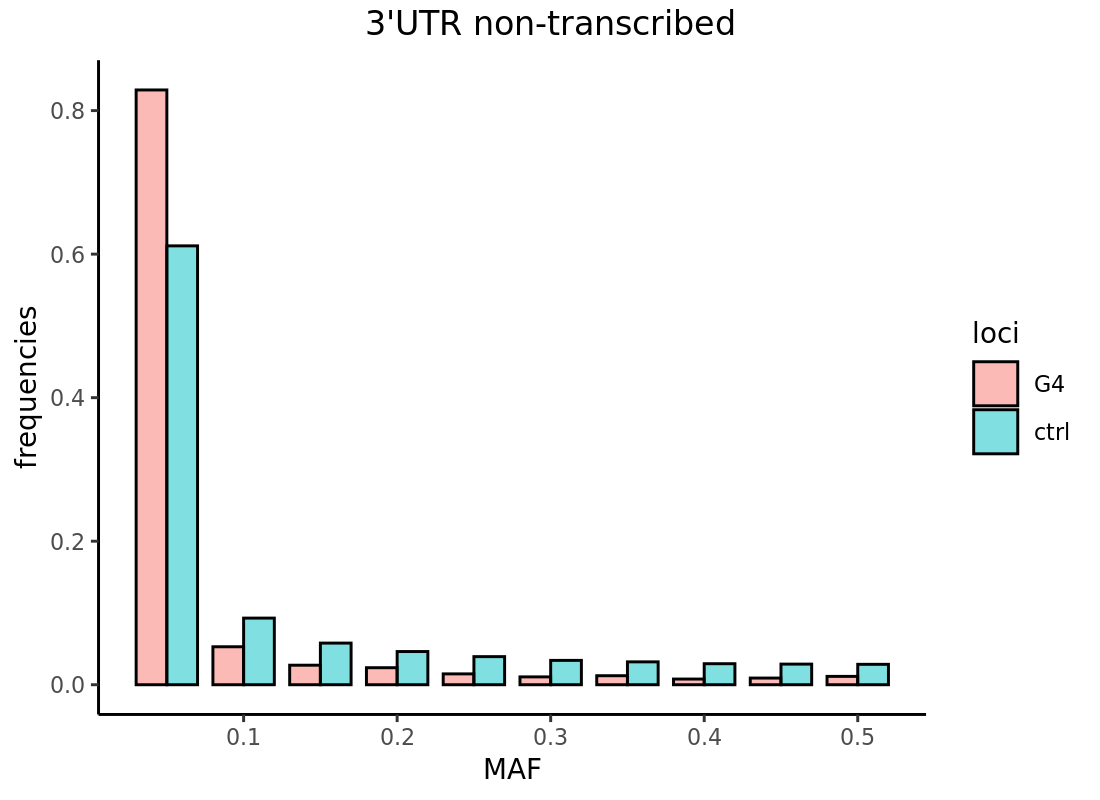

In [777]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)



hist_high <- hist(TUTR_sense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(TUTR_sense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(TUTR_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(TUTR_sense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("3'UTR non-transcribed",gp=gpar(fontsize=12,font=1)))



In [662]:
TUTR_antisense_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.high.antisens.test')
TUTR_antisense_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.low.antisens.test')
TUTR_antisense_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TUTR.SFS.control')

TUTR_antisense_MAFs_high = list_MAFs(TUTR_antisense_high_infile)
TUTR_antisense_MAFs_low = list_MAFs(TUTR_antisense_low_infile)
TUTR_antisense_MAFs_ctrl = list_MAFs(TUTR_antisense_ctrl_infile)



In [663]:
%%R -i TUTR_antisense_MAFs_ctrl,TUTR_antisense_MAFs_high,TUTR_antisense_MAFs_low

TUTR_antisense_MAFs_high <- as.numeric(as.character(TUTR_antisense_MAFs_high))
TUTR_antisense_MAFs_low <- as.numeric(as.character(TUTR_antisense_MAFs_low))
TUTR_antisense_MAFs_ctrl <- as.numeric(as.character(TUTR_antisense_MAFs_ctrl))
TUTR_antisense_MAFs <- c(TUTR_template_MAFs_high,TUTR_antisense_MAFs_low)

KS <- ks.test(TUTR_antisense_MAFs_high,TUTR_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(TUTR_antisense_MAFs_low,TUTR_antisense_MAFs_ctrl)
print(KS)

KS <- ks.test(TUTR_antisense_MAFs,TUTR_antisense_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  TUTR_antisense_MAFs_high and TUTR_antisense_MAFs_ctrl
D = 0.028793, p-value = 0.07669
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TUTR_antisense_MAFs_low and TUTR_antisense_MAFs_ctrl
D = 0.02272, p-value = 0.6326
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TUTR_antisense_MAFs and TUTR_antisense_MAFs_ctrl
D = 0.53102, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.83070208   G4
2 0.10 0.04058321   G4
3 0.15 0.02284547   G4
4 0.20 0.02089525   G4
5 0.25 0.01532318   G4
6 0.30 0.01569465   G4


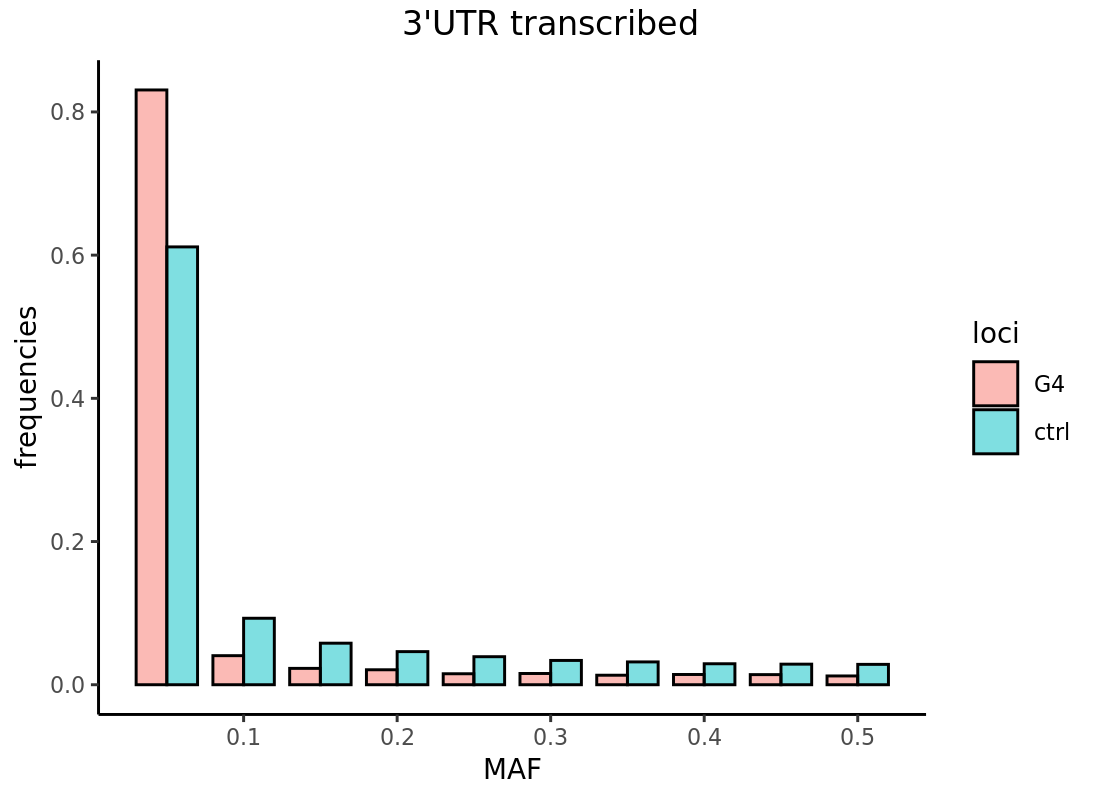

In [778]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(TUTR_antisense_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(TUTR_antisense_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(TUTR_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(TUTR_antisense_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("3'UTR transcribed",gp=gpar(fontsize=12,font=1)))



In [665]:
Down_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Downstream1k.SFS.high.test')
Down_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Downstream1k.SFS.low.test')
Down_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Downstream1k.SFS.control')

Down_MAFs_high = list_MAFs(Down_high_infile)
Down_MAFs_low = list_MAFs(Down_low_infile)
Down_MAFs_ctrl = list_MAFs(Down_ctrl_infile)


In [666]:
%%R -i Down_MAFs_ctrl,Down_MAFs_high,Down_MAFs_low

Down_MAFs_high <- as.numeric(as.character(Down_MAFs_high))
Down_MAFs_low <- as.numeric(as.character(Down_MAFs_low))
Down_MAFs_ctrl <- as.numeric(as.character(Down_MAFs_ctrl))
Down_MAFs <- c(Down_MAFs_high,Down_MAFs_low)

KS <- ks.test(Down_MAFs_high,Down_MAFs_ctrl)
print(KS)

KS <- ks.test(Down_MAFs_low,Down_MAFs_ctrl)
print(KS)

KS <- ks.test(Down_MAFs,Down_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  Down_MAFs_high and Down_MAFs_ctrl
D = 0.075798, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  Down_MAFs_low and Down_MAFs_ctrl
D = 0.043864, p-value = 0.00118
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  Down_MAFs and Down_MAFs_ctrl
D = 0.065295, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.65903987   G4
2 0.10 0.09713644   G4
3 0.15 0.05586749   G4
4 0.20 0.04126895   G4
5 0.25 0.03228523   G4
6 0.30 0.02554745   G4


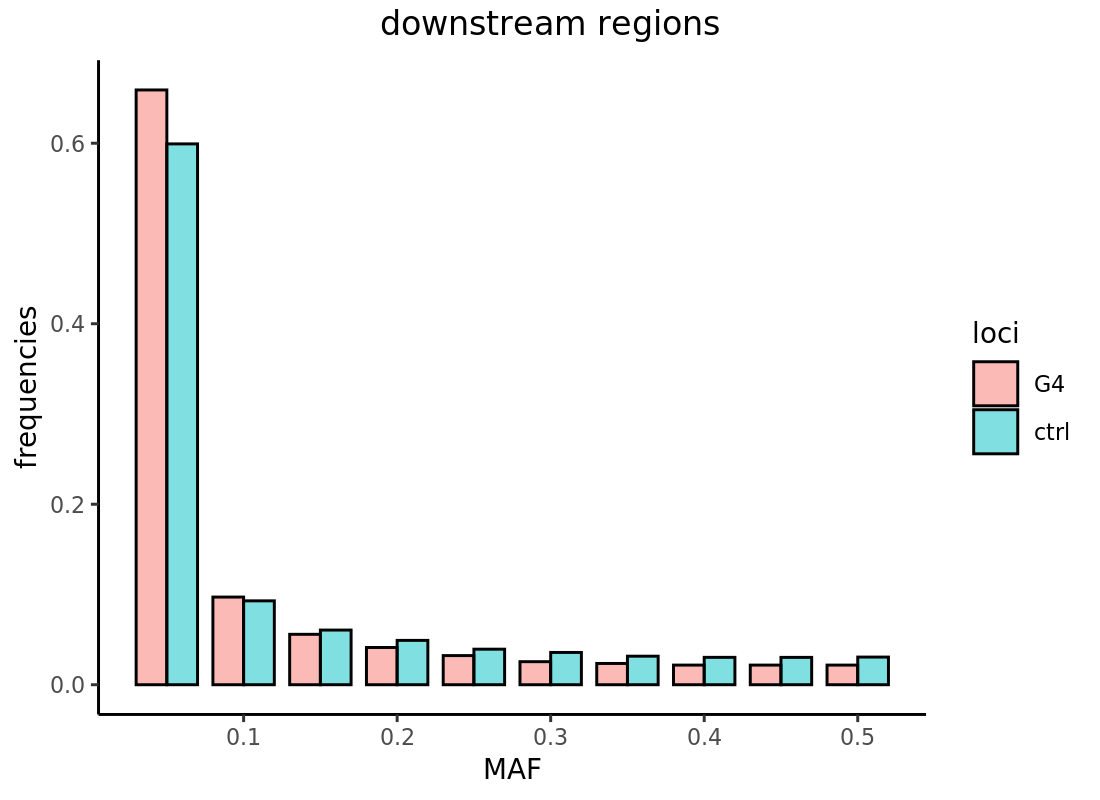

In [779]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(Down_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(Down_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(Down_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(Down_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("downstream regions",gp=gpar(fontsize=12,font=1)))



In [668]:
RepOrigin_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/RepOrigin.SFS.high.test')
RepOrigin_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/RepOrigin.SFS.low.test')
RepOrigin_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/RepOrigin.SFS.control')

RepOrigin_MAFs_high = list_MAFs(RepOrigin_high_infile)
RepOrigin_MAFs_low = list_MAFs(RepOrigin_low_infile)
RepOrigin_MAFs_ctrl = list_MAFs(RepOrigin_ctrl_infile)


In [669]:
%%R -i RepOrigin_MAFs_ctrl,RepOrigin_MAFs_high,RepOrigin_MAFs_low

RepOrigin_MAFs_high <- as.numeric(as.character(RepOrigin_MAFs_high))
RepOrigin_MAFs_low <- as.numeric(as.character(RepOrigin_MAFs_low))
RepOrigin_MAFs_ctrl <- as.numeric(as.character(RepOrigin_MAFs_ctrl))
RepOrigin_MAFs <- c(RepOrigin_MAFs_high,RepOrigin_MAFs_low)

KS <- ks.test(RepOrigin_MAFs_high,RepOrigin_MAFs_ctrl)
print(KS)

KS <- ks.test(RepOrigin_MAFs_low,RepOrigin_MAFs_ctrl)
print(KS)

KS <- ks.test(RepOrigin_MAFs,RepOrigin_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  RepOrigin_MAFs_high and RepOrigin_MAFs_ctrl
D = 0.072784, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  RepOrigin_MAFs_low and RepOrigin_MAFs_ctrl
D = 0.022511, p-value = 1.161e-12
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  RepOrigin_MAFs and RepOrigin_MAFs_ctrl
D = 0.060897, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.64907669   G4
2 0.10 0.09814519   G4
3 0.15 0.05617655   G4
4 0.20 0.04150186   G4
5 0.25 0.03291979   G4
6 0.30 0.02751505   G4


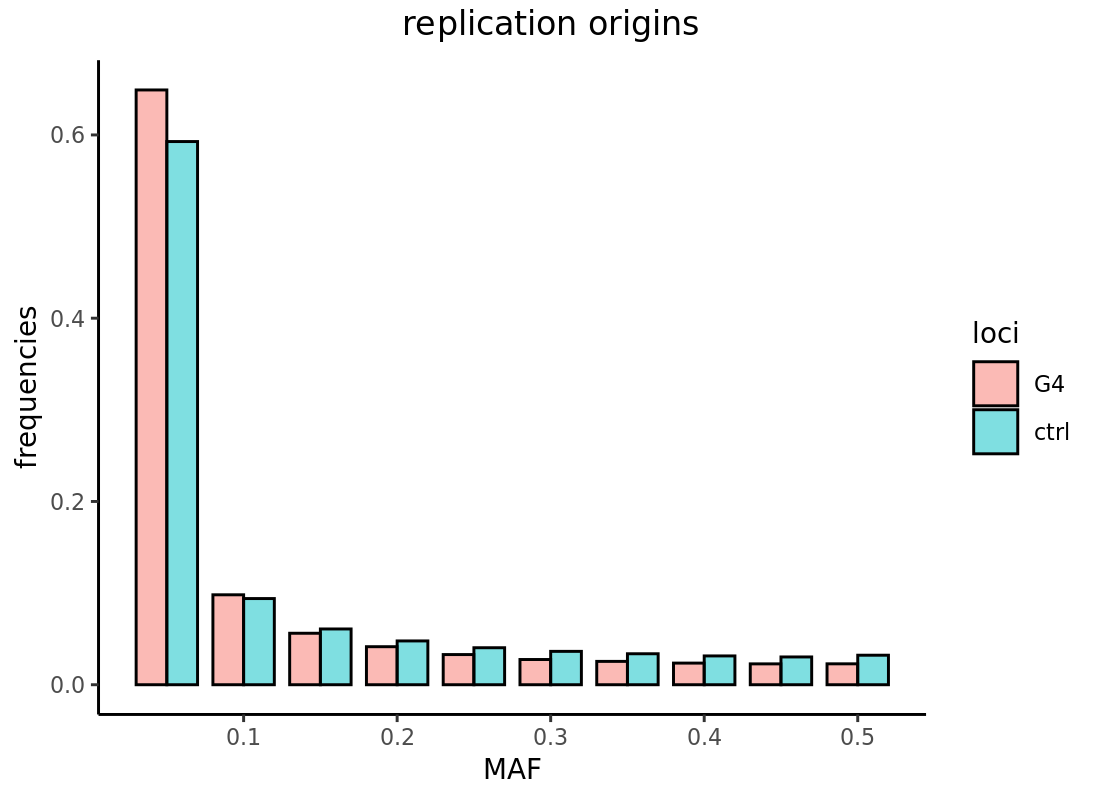

In [780]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(RepOrigin_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(RepOrigin_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(RepOrigin_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(RepOrigin_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("replication origins",gp=gpar(fontsize=12,font=1)))



In [672]:
enhancers_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/enhancers.SFS.high.test')
enhancers_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/enhancers.SFS.low.test')
enhancers_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/enhancers.SFS.control')

enhancers_MAFs_high = list_MAFs(enhancers_high_infile)
enhancers_MAFs_low = list_MAFs(enhancers_low_infile)
enhancers_MAFs_ctrl = list_MAFs(enhancers_ctrl_infile)


In [673]:
%%R -i enhancers_MAFs_ctrl,enhancers_MAFs_high,enhancers_MAFs_low

enhancers_MAFs_high <- as.numeric(as.character(enhancers_MAFs_high))
enhancers_MAFs_low <- as.numeric(as.character(enhancers_MAFs_low))
enhancers_MAFs_ctrl <- as.numeric(as.character(enhancers_MAFs_ctrl))
enhancers_MAFs <- c(enhancers_MAFs_high,enhancers_MAFs_low)

KS <- ks.test(enhancers_MAFs_high,enhancers_MAFs_ctrl)
print(KS)

KS <- ks.test(enhancers_MAFs_low,enhancers_MAFs_ctrl)
print(KS)

KS <- ks.test(enhancers_MAFs,enhancers_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  enhancers_MAFs_high and enhancers_MAFs_ctrl
D = 0.055282, p-value = 2.376e-12
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  enhancers_MAFs_low and enhancers_MAFs_ctrl
D = 0.054629, p-value = 0.0001994
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  enhancers_MAFs and enhancers_MAFs_ctrl
D = 0.054013, p-value = 2.109e-15
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.64209180   G4
2 0.10 0.10011195   G4
3 0.15 0.06284983   G4
4 0.20 0.03950104   G4
5 0.25 0.03262434   G4
6 0.30 0.02926595   G4


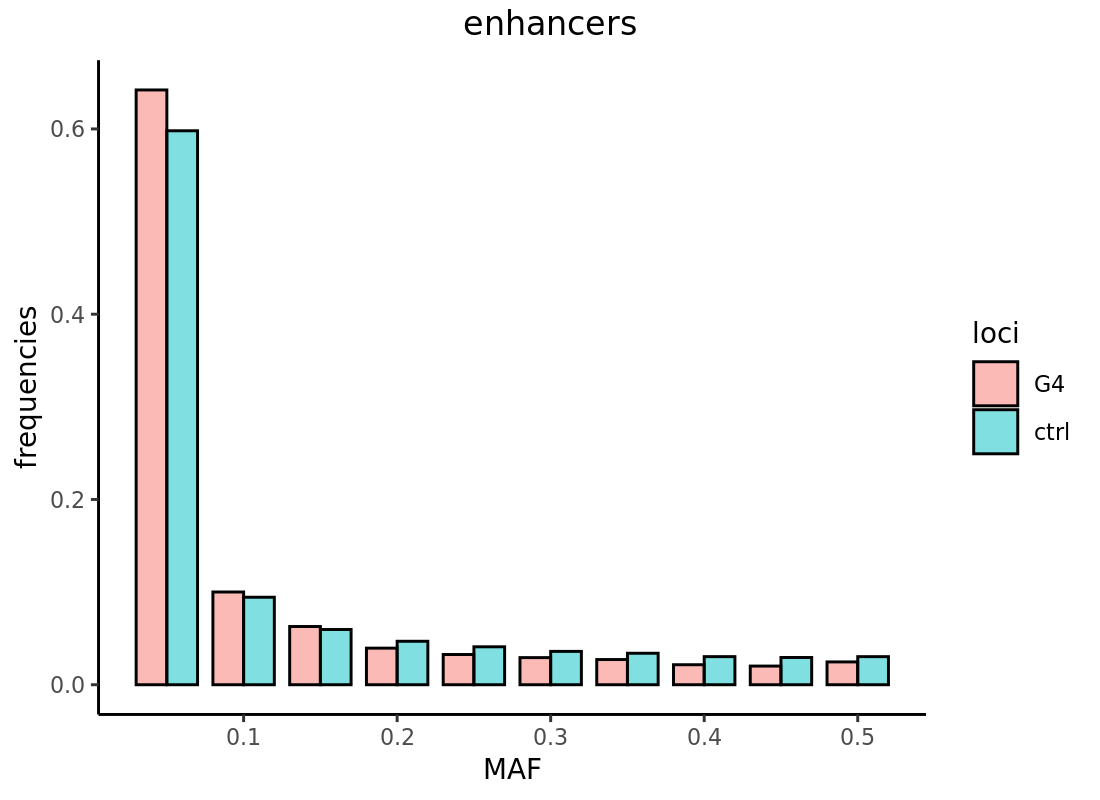

In [781]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(enhancers_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(enhancers_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(enhancers_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(enhancers_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("enhancers",gp=gpar(fontsize=12,font=1)))



In [675]:
TADB_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TADB.SFS.high.test')
TADB_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TADB.SFS.low.test')
TADB_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/TADB.SFS.control.shuf')

TADB_MAFs_high = list_MAFs(TADB_high_infile)
TADB_MAFs_low = list_MAFs(TADB_low_infile)
TADB_MAFs_ctrl = list_MAFs(TADB_ctrl_infile)


In [676]:
%%R -i TADB_MAFs_ctrl,TADB_MAFs_high,TADB_MAFs_low

TADB_MAFs_high <- as.numeric(as.character(TADB_MAFs_high))
TADB_MAFs_low <- as.numeric(as.character(TADB_MAFs_low))
TADB_MAFs_ctrl <- as.numeric(as.character(TADB_MAFs_ctrl))
TADB_MAFs <- c(TADB_MAFs_high,TADB_MAFs_low)

KS <- ks.test(TADB_MAFs_high,TADB_MAFs_ctrl)
print(KS)

KS <- ks.test(TADB_MAFs_low,TADB_MAFs_ctrl)
print(KS)

KS <- ks.test(TADB_MAFs,TADB_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  TADB_MAFs_high and TADB_MAFs_ctrl
D = 0.080175, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TADB_MAFs_low and TADB_MAFs_ctrl
D = 0.039796, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  TADB_MAFs and TADB_MAFs_ctrl
D = 0.067812, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.65619298   G4
2 0.10 0.09745349   G4
3 0.15 0.05501555   G4
4 0.20 0.04071656   G4
5 0.25 0.03159320   G4
6 0.30 0.02718645   G4


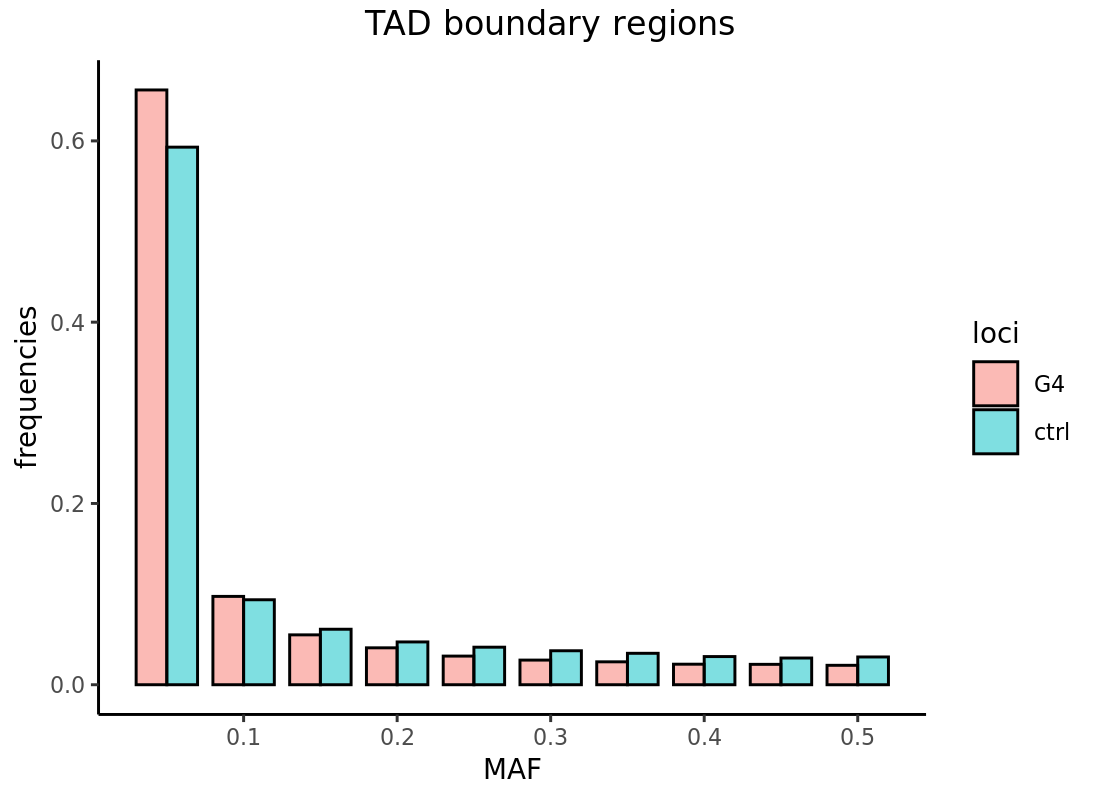

In [782]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(TADB_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(TADB_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(TADB_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(TADB_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("TAD boundary regions",gp=gpar(fontsize=12,font=1)))



In [678]:
CpGI_high_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/CpGIsland.SFS.high.test')
CpGI_low_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/CpGIsland.SFS.low.test')
CpGI_ctrl_infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/CpGIsland.SFS.control')

CpGI_MAFs_high = list_MAFs(CpGI_high_infile)
CpGI_MAFs_low = list_MAFs(CpGI_low_infile)
CpGI_MAFs_ctrl = list_MAFs(CpGI_ctrl_infile)


In [679]:
%%R -i CpGI_MAFs_ctrl,CpGI_MAFs_high,CpGI_MAFs_low

CpGI_MAFs_high <- as.numeric(as.character(CpGI_MAFs_high))
CpGI_MAFs_low <- as.numeric(as.character(CpGI_MAFs_low))
CpGI_MAFs_ctrl <- as.numeric(as.character(CpGI_MAFs_ctrl))
CpGI_MAFs <- c(CpGI_MAFs_high,CpGI_MAFs_low)

KS <- ks.test(CpGI_MAFs_high,CpGI_MAFs_ctrl)
print(KS)

KS <- ks.test(CpGI_MAFs_low,CpGI_MAFs_ctrl)
print(KS)

KS <- ks.test(CpGI_MAFs,CpGI_MAFs_ctrl)
print(KS)



	Two-sample Kolmogorov-Smirnov test

data:  CpGI_MAFs_high and CpGI_MAFs_ctrl
D = 0.054079, p-value < 2.2e-16
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  CpGI_MAFs_low and CpGI_MAFs_ctrl
D = 0.020424, p-value = 0.002847
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  CpGI_MAFs and CpGI_MAFs_ctrl
D = 0.040372, p-value < 2.2e-16
alternative hypothesis: two-sided



     x        MAF loci
1 0.05 0.66681343   G4
2 0.10 0.09598239   G4
3 0.15 0.05430196   G4
4 0.20 0.04043295   G4
5 0.25 0.03107687   G4
6 0.30 0.02373876   G4


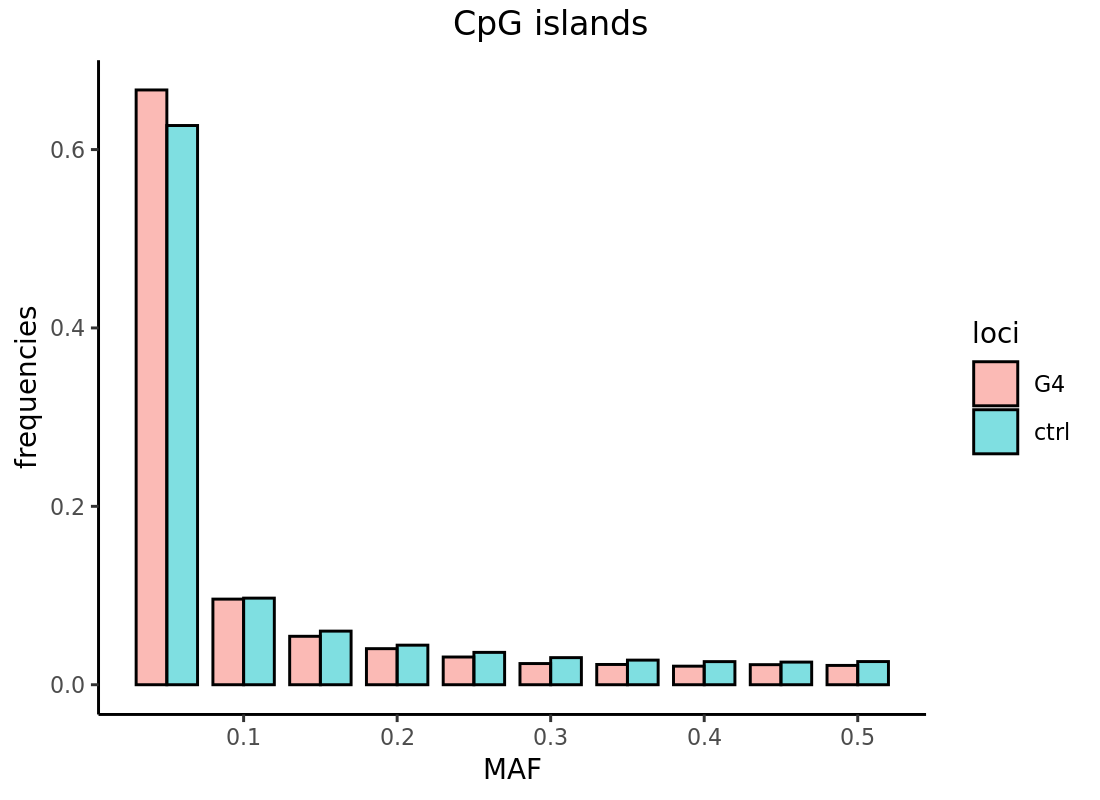

In [783]:
%%R -w 5.5 -h 4 --units in -r 200

library(scales) 
library(plotrix)


hist_high <- hist(CpGI_MAFs, plot=FALSE, breaks = 10)$density / sum(hist(CpGI_MAFs, plot=FALSE, breaks = 10)$density)
hist_ctrl <- hist(CpGI_MAFs_ctrl, plot=FALSE, breaks = 10)$density / sum(hist(CpGI_MAFs_ctrl, plot=FALSE, breaks = 10)$density)
x <- seq(0.05,0.5,0.05)

toplot <- cbind.data.frame(c(x,x),c(hist_high,hist_ctrl),c(rep('G4',length(hist_high)),rep('ctrl',length(hist_ctrl))))
colnames(toplot) <- c('x','MAF', 'loci')
print(head(toplot))

p1 <- ggplot(toplot) + 
    geom_bar(aes(fill = loci, x=x, y=MAF), position = "dodge", stat="identity", colour="black", width = 0.04, alpha = .5) +
    theme_classic() +
    scale_x_continuous(breaks=seq(0,0.5,0.1)) +
    labs(y="frequencies", x="MAF") +
    theme(text=element_text(size=10,family="sans"))

grid.arrange(p1,top=textGrob("CpG islands",gp=gpar(fontsize=12,font=1)))



In [11]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch6/wilfried/nonB/Selection_Errors/Exons.nooverlap', 'rt')

length = 0

for line in infile:
    array = line.strip().split('\t')
    currentlength = int(array[2]) - int(array[1]) + 1
    length += currentlength
    
    
print(str(length)+' bp in Exons')
    


33683716 bp in Exons


In [12]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch6/wilfried/nonB/Selection_Errors/Exons.Quadron.intersect', 'rt')


length = 0

for line in infile:
    array = line.strip().split('\t')
    if array[4] != '-1':
        start, end, G4start, G4end = int(array[1]), int(array[2]), int(array[4]), int(array[5])
        
        if G4start < start:
            G4start = start
            
        if G4end > end:
            G4end = end
            
        currentlength = G4end - G4start + 1
        length += currentlength
        
print(str(length)+' bp of G4s in Exons')




590145 bp of G4s in Exons


In [13]:
print(str(33683716-590145)+' bp of Exons without G4')

33093571 bp of Exons without G4


In [21]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.sens.test', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if ref != 'NA' and homo == 'NA':
        count += 1
        
print(str(count)+' SNPs in '+str(span)+' bp')

82 SNPs in 81366 bp


In [22]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.antisens.test', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if ref != 'NA' and homo == 'NA':
        count += 1
        
print(str(count)+' SNPs in '+str(span)+' bp')

490 SNPs in 339140 bp


In [19]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.control', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS, score, strand = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if ref != 'NA' and homo == 'NA':
        count += 1
        
print(str(count)+' SNPs in '+str(span)+' bp')

25811 SNPs in 63142846 bp


In [25]:
%%R
fisher.test(cbind(c(82 + 490, 81366 + 339140),c(25811, 63142846)))


	Fisher's Exact Test for Count Data

data:  cbind(c(82 + 490, 81366 + 339140), c(25811, 63142846))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.057339 3.615870
sample estimates:
odds ratio 
  3.327667 



In [26]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.sens.test', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if homo != 'NA':
        count += 1
        
print(str(count)+' FNSs in '+str(span)+' bp')

36885 FNSs in 81366 bp


In [27]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.high.antisens.test', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if homo != 'NA':
        count += 1
        
print(str(count)+' FNSs in '+str(span)+' bp')

155558 FNSs in 339140 bp


In [8]:
infile = open('/nfs/brubeck.bx.psu.edu/scratch5/wilfried/nonB/Mutation/Exons.SFS.control', 'rt')

span = 0
count = 0

for line in infile:
    chrom, start, end, SFS, score, strand = line.strip().split('\t')
    span += int(end) - int(start) + 1
    
    homo, pongo, ref, alt, MAF = SFS.split('|')
    
    if homo != 'NA':
        count += 1
        
print(str(count)+' FNSs in '+str(span)+' bp')

30134931 FNSs in 63142846 bp


In [28]:
%%R
fisher.test(cbind(c(36885+155558, 81366+339140),c(30134931, 63142846)))


	Fisher's Exact Test for Count Data

data:  cbind(c(36885 + 155558, 81366 + 339140), c(30134931, 63142846))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.9537570 0.9641387
sample estimates:
odds ratio 
 0.9589287 

